<center> Business Analytics Project

<center> By

<center> Saar Golan

# Introduction

I have been given:
* Server logs with data on website visits from June 2017 through May 2018
* Dump file with all orders for this period
* Marketing expenses statistics

My first task is to help optimize marketing expenses.

# Project objective

Study:
* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off

# Description of the data

**The visits table (server logs with data on website visits):**
* Uid — user's unique identifier
* Device — user's device (categorical with 2 categories - desktop and touch)
* Start Ts — session start date and time (datetime)
* End Ts — session end date and time (datetime)
* Source Id — identifier of the ad source the user came from  
  All dates in this table are in YYYY-MM-DD format.

**The orders table (data on orders):**
* Uid — unique identifier of the user making an order
* Buy Ts — order date and time (datetime)
* Revenue — Yandex.Afisha's revenue from the order (float)

**The costs table (data on marketing expenses):**
* source_id — ad source identifier (categorical with a max of 10 categories - 1-10)
* dt — date (datetime)
* costs — expenses on this ad source on this day (float)

# General set-up

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
from functools import reduce
import seaborn as sns
import math
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None) #was -1
plt.rcParams.update({'figure.max_open_warning': 0})


#Install jupyter extensions and packages
'''
#!pip install jupyterthemes
#!pip install --upgrade jupyterthemes
#!jt -t monokai -T -T -kl
#install theme and enable the toolbar, filename, logo, kernel
#!jt -r #install original theme

!pip install plotly==5.5.0
!pip install -U seaborn
!pip install jupyter_contrib_nbextensions
!jupyter nbextension enable toc2/main
!jupyter nbextension enable varInspector/main
!jupyter nbextension enable execute_time/ExecuteTime
!jupyter nbextension enable highlighter/highlighter
!jupyter nbextension enable move_selected_cells/main
#!pip install jupyter_latex_envs [--user][--upgrade]
#!jupyter nbextension install --py latex_envs [--user|--sys-prefix|--system]
#!jupyter nbextension enable --py latex_envs [--user|--sys-prefix|--system]
'''

#Output all cell commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/  
#http://www.xavierdupre.fr/app/pymyinstall/helpsphinx/blog/2016/2016-10-29-nbextensions.html  
#https://reposhub.com/python/miscellaneous/lckr-jupyterlab-variableInspector.html  
#https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result

'\n#!pip install jupyterthemes\n#!pip install --upgrade jupyterthemes\n#!jt -t monokai -T -T -kl\n#install theme and enable the toolbar, filename, logo, kernel\n#!jt -r #install original theme\n\n!pip install plotly==5.5.0\n!pip install -U seaborn\n!pip install jupyter_contrib_nbextensions\n!jupyter nbextension enable toc2/main\n!jupyter nbextension enable varInspector/main\n!jupyter nbextension enable execute_time/ExecuteTime\n!jupyter nbextension enable highlighter/highlighter\n!jupyter nbextension enable move_selected_cells/main\n#!pip install jupyter_latex_envs [--user][--upgrade]\n#!jupyter nbextension install --py latex_envs [--user|--sys-prefix|--system]\n#!jupyter nbextension enable --py latex_envs [--user|--sys-prefix|--system]\n'

# Step 1. Download the data and prepare it for analysis

Here, we will:
* Store the data on visits, orders, and costs in proper variables.  
* Optimize the data for analysis.  
* Make sure each column contains the correct data type.

## Import the data

In [190]:
try:
    visits = pd.read_csv('visits_log_us.csv',
                         dtype={'Device': 'category', 'Source Id': 'category'},
                         parse_dates=['Start Ts', 'End Ts'],)
    orders = pd.read_csv('orders_log_us.csv',
                        parse_dates=['Buy Ts'])
    costs = pd.read_csv('costs_us.csv',
                        dtype={'source_id': 'category'},
                        parse_dates=['dt'])
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv',
                         dtype={'Device': 'category', 'Source Id': 'category'},
                         parse_dates=['Start Ts', 'End Ts'],)
    orders = pd.read_csv('/datasets/orders_log_us.csv',
                        parse_dates=['Buy Ts'])
    costs = pd.read_csv('/datasets/costs_us.csv',
                        dtype={'source_id': 'category'},
                        parse_dates=['dt'])

## Examine the data

Define a function to examine data:

In [191]:
def examine(fname):
    print('\n***************\n head:\n', fname.head())
    print('\n***************\n tail:\n', fname.tail())
    print('\n***************\n info:\n', fname.info(memory_usage='deep'))
    print('\n***************\n describe:\n', fname.describe())
    
    # Exploring categorical variables
    for column in fname.select_dtypes(exclude=['number','datetime64[ns]']).columns:
        print('===============', column, '===============')
        print(fname[column].value_counts())        
        print('Total No. of values:' , fname[column].value_counts().count())
        print('\n')

#https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical  

In [192]:
examine(visits)


***************
 head:
     Device              End Ts Source Id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  

***************
 tail:
          Device              End Ts Source Id            Start Ts  \
359395  desktop 2017-07-29 19:07:19         2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19         1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19         4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19         5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19         2 2017-09-10 13:13:0

Checking the low frequency 'Source Id' values 6 and 7:

In [193]:
print(visits[visits['Source Id'].isin(['6', '7'])])

         Device              End Ts Source Id            Start Ts  \
14834   desktop 2017-12-02 23:34:00         7 2017-12-02 23:21:00   
16044   desktop 2017-12-28 01:09:00         6 2017-12-28 00:48:00   
33671   desktop 2017-12-25 09:50:00         7 2017-12-25 09:49:00   
37719   desktop 2018-02-02 11:30:00         7 2018-02-02 11:28:00   
41606   desktop 2017-07-05 22:29:00         7 2017-07-05 22:22:00   
42765   desktop 2017-10-14 22:27:00         7 2017-10-14 22:26:00   
45637     touch 2017-10-02 21:28:00         7 2017-10-02 21:26:00   
74848   desktop 2017-07-01 18:32:00         6 2017-07-01 18:26:00   
83135   desktop 2017-08-17 11:56:00         7 2017-08-17 10:28:00   
91126     touch 2017-08-28 16:27:00         6 2017-08-28 16:24:00   
94664   desktop 2018-02-09 17:01:00         7 2018-02-09 16:58:00   
110267  desktop 2017-09-22 22:16:00         7 2017-09-22 21:56:00   
116398    touch 2018-01-10 17:38:00         7 2018-01-10 17:17:00   
116965    touch 2018-02-12 00:30:0

Nothing seems out of the ordinary

Investigate time span:

In [194]:
print(visits['End Ts'].min())
print(visits['End Ts'].max())
print(visits['Start Ts'].min())
print(visits['Start Ts'].max())

2017-06-01 00:02:00
2018-06-01 01:26:00
2017-06-01 00:01:00
2018-05-31 23:59:00


In [195]:
examine(orders)


***************
 head:
                Buy Ts  Revenue                   Uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

***************
 tail:
                    Buy Ts  Revenue                   Uid
50410 2018-05-31 23:50:00     4.64  12296626599487328624
50411 2018-05-31 23:50:00     5.80  11369640365507475976
50412 2018-05-31 23:54:00     0.30   1786462140797698849
50413 2018-05-31 23:56:00     3.67   3993697860786194247
50414 2018-06-01 00:02:00     3.42     83872787173869366
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2

Investigate time span:

In [196]:
print(orders['Buy Ts'].min())
print(orders['Buy Ts'].max())

2017-06-01 00:10:00
2018-06-01 00:02:00


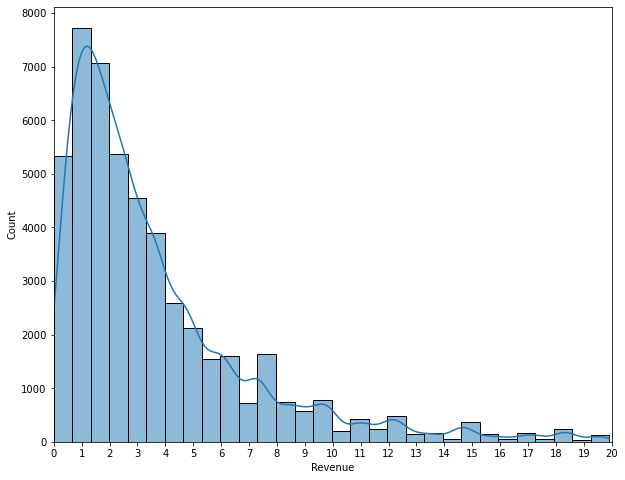

In [197]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = orders[orders['Revenue'] < 20], x = "Revenue", bins=30, kde=True)
x1 = ax.set_xlim(0,20)
x2 = ax.set_xticks(range(0,21))
fig.set_size_inches(10,8)
plt.show()

We can see that the distribution is strongly affected by the presence of high revenue outliers. 

In [198]:
examine(costs)


***************
 head:
   source_id         dt  costs
0         1 2017-06-01  75.20
1         1 2017-06-02  62.25
2         1 2017-06-03  36.53
3         1 2017-06-04  55.00
4         1 2017-06-05  57.08

***************
 tail:
      source_id         dt  costs
2537        10 2018-05-27   9.92
2538        10 2018-05-28  21.26
2539        10 2018-05-29  11.32
2540        10 2018-05-30  33.15
2541        10 2018-05-31  17.60
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   category      
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 43.0 KB

***************
 info:
 None

***************
 describe:
              costs
count  2542.000000
mean    129.477427
std     156.296628
min       0.540000
25% 

Investigate time span:

In [199]:
print(costs['dt'].min())
print(costs['dt'].max())

2017-06-01 00:00:00
2018-05-31 00:00:00


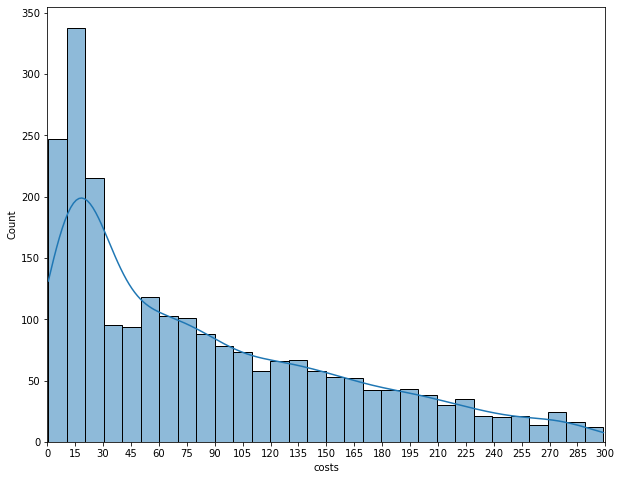

In [200]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = costs[costs['costs'] < 300], x = "costs", bins=30, kde=True)
x1 = ax.set_xlim(0,300)
x2 = ax.set_xticks(range(0,310,15))
fig.set_size_inches(10,8)
plt.show()

We can see that the distribution is affected by the presence of high costs outliers. 

Correct visits Source Id to source_id for column name consistency:

In [201]:
visits = visits.rename(columns={'Source Id': 'source_id'}) 
print(visits.head())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  


The gods of Data Science spared us from nulls 😉

Creating the data segmentation for the analysis.  
(I am assuming there is a small possibility that sessions pass midnight so the start and end day are different.  
We will further discuss this below...)

In [202]:
visits['start_day']  = visits['Start Ts'].astype('datetime64[D]') #not necessary, just for consistency...
visits['start_week']  = visits['Start Ts'].astype('datetime64[W]')
visits['start_month'] = visits['Start Ts'].astype('datetime64[M]')

In [203]:
visits['end_day']  = visits['End Ts'].astype('datetime64[D]') #not necessary, just for consistency...
visits['end_week']  = visits['End Ts'].astype('datetime64[W]')
visits['end_month'] = visits['End Ts'].astype('datetime64[M]')

In [204]:
orders['buy_day']  = orders['Buy Ts'].astype('datetime64[D]') #not necessary, just for consistency...
orders['buy_week']  = orders['Buy Ts'].astype('datetime64[W]')
orders['buy_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [205]:
costs['dt_day']  = costs['dt'].astype('datetime64[D]') #not necessary, just for consistency...
costs['dt_week']  = costs['dt'].astype('datetime64[W]')
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

In [206]:
print(visits.head())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  
0 2017-12-14 2017-12-01  
1 2018-02-15 2018-02-01  
2 2017-06-29 2017-07-01  
3 2018-05-17 2018-05-01  
4 2017-12-21 2017-12-01  


In [207]:
print(orders.head())

               Buy Ts  Revenue                   Uid    buy_day   buy_week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-06-01   

   buy_month  
0 2017-06-01  
1 2017-06-01  
2 2017-06-01  
3 2017-06-01  
4 2017-06-01  


In [208]:
print(costs.head())

  source_id         dt  costs     dt_day    dt_week   dt_month
0         1 2017-06-01  75.20 2017-06-01 2017-06-01 2017-06-01
1         1 2017-06-02  62.25 2017-06-02 2017-06-01 2017-06-01
2         1 2017-06-03  36.53 2017-06-03 2017-06-01 2017-06-01
3         1 2017-06-04  55.00 2017-06-04 2017-06-01 2017-06-01
4         1 2017-06-05  57.08 2017-06-05 2017-06-01 2017-06-01


# Step 2. Make reports and calculate metrics:

## Product 

### Active Users

Let us investigate how many people use Yandex.Afisha every day, week, and month?  
Let us look for visits dataframe DAU/WAU,MAU.  
(DAU/WAU,MAU include only unique users.)

In [209]:
visits_dau = visits.groupby(visits['start_day'])['Uid'].nunique().reset_index()
visits_wau = visits.groupby(visits['start_week'])['Uid'].nunique().reset_index()
visits_mau = visits.groupby(visits['start_month'])['Uid'].nunique().reset_index()

#Remark - it is important to use Start Ts rather than End Ts to ensure we do not miss certain users at the last day.
#(We may miss a few on the first day - if their session started before the monitored period...)

In [210]:
visits_dau = visits_dau.rename(columns={'Uid': 'DAU'}) 
visits_wau = visits_wau.rename(columns={'Uid': 'WAU'}) 
visits_mau = visits_mau.rename(columns={'Uid': 'MAU'})

In [213]:
print(visits_dau.head())
print(visits_dau.tail())

print(visits_wau.head())
print(visits_wau.tail())

print(visits_mau.head())
print(visits_mau.tail())

   start_day  DAU
0 2017-06-01  605
1 2017-06-02  608
2 2017-06-03  445
3 2017-06-04  476
4 2017-06-05  820
     start_day   DAU
359 2018-05-27   620
360 2018-05-28  1039
361 2018-05-29   948
362 2018-05-30  1289
363 2018-05-31  1997
  start_week   WAU
0 2017-06-01  4082
1 2017-06-08  3311
2 2017-06-15  2844
3 2017-06-22  3079
4 2017-06-29  3055
   start_week   WAU
48 2018-05-03  4140
49 2018-05-10  4692
50 2018-05-17  5234
51 2018-05-24  5609
52 2018-05-31  1997
  start_month    MAU
0  2017-06-01  13259
1  2017-07-01  14183
2  2017-08-01  11631
3  2017-09-01  18975
4  2017-10-01  29692
   start_month    MAU
7   2018-01-01  28716
8   2018-02-01  28749
9   2018-03-01  27473
10  2018-04-01  21008
11  2018-05-01  20701


Build a graph that will show the dynamics of these metrics.  

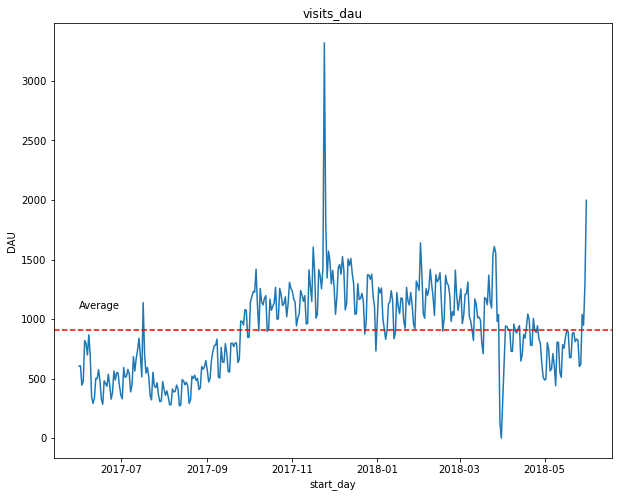

In [214]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'start_day', y = 'DAU',data = visits_dau)
fig1 = fig.set_size_inches(10,8)
x1 = line_plot.set_title("visits_dau")
x2 = ax.axhline(visits_dau.DAU.mean(), ls='--', c='red')
x3 = ax.text(visits_dau.start_day.min(),1.2 * visits_dau.DAU.mean(),"Average")
plt.show()

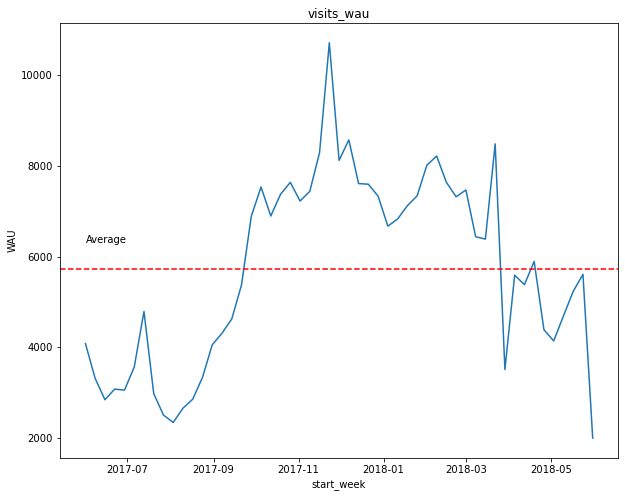

In [215]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'start_week', y = 'WAU',data = visits_wau)
#x1 = ax.set_xlim(0,300)
#x2 = ax.set_xticks(range(0,310,15))
fig1 = fig.set_size_inches(10,8)
x1 = line_plot.set_title("visits_wau")
x2 = ax.axhline(visits_wau.WAU.mean(), ls='--', c='red')
x3 = ax.text(visits_wau.start_week.min(),1.1 * visits_wau.WAU.mean(),"Average")
plt.show()

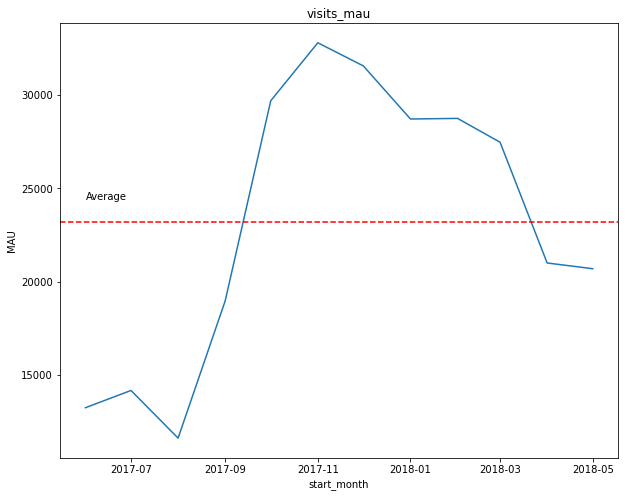

In [216]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'start_month', y = 'MAU',data = visits_mau)
#x1 = ax.set_xlim(0,300)
#x2 = ax.set_xticks(range(0,310,15))
fig1 = fig.set_size_inches(10,8)
x1 = line_plot.set_title("visits_mau")
x2 = ax.axhline(visits_mau.MAU.mean(), ls='--', c='red')
x3 = ax.text(visits_mau.start_month.min(),1.05 * visits_mau.MAU.mean(),"Average")
plt.show()

### sticky factor

Let us calculate sticky factor:  

sticky factor = DAU/WAU or DAU/MAU

In [220]:
sticky_df = pd.merge(visits, visits_dau, how='left', on='start_day')

In [221]:
sticky_df = pd.merge(sticky_df, visits_wau, how='left', on='start_week')

In [222]:
sticky_df = pd.merge(sticky_df, visits_mau, how='left', on='start_month')

In [223]:
sticky_df['sf_DAU_by_WAU'] = sticky_df['DAU'] / sticky_df['WAU'] * 100
sticky_df['sf_DAU_by_MAU'] = sticky_df['DAU'] / sticky_df['MAU'] * 100

In [224]:
examine(sticky_df)


***************
 head:
     Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month   DAU   WAU    MAU  sf_DAU_by_WAU  sf_DAU_by_MAU  
0 2017-12-14 2017-12-01  1173  7611  31557      15.411904       3.717083  
1 2018-

One can notice the 100% weekly sticky factor for the end of the monitored period.  
This is a caveat of the calculation.  
The first day of the database is a Thursday.  
Therefore, the following weeks are counted by Thursdays.  
As a result, the last week lasts only one day and for this week DAU=WAU and sticky factor becomes 100%.  
This is obviously not true because we do not know how many users will return on this week (we do not have this future data).  
Thus, we must remove this day from the weekly sticky factor calculations.  
We do not have this problem for the monthly calculations as the last day accounted for is also the last day of the month.  
Shifting the data by 5 days to a sunday [- pd.Timedelta(days=5)] will not solve the problem because then we will have only shifted it to the first week of the monitored period where we have missing days as well...

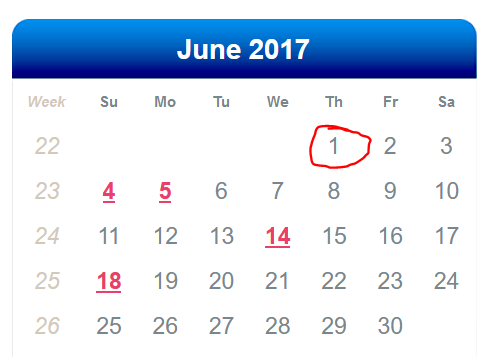
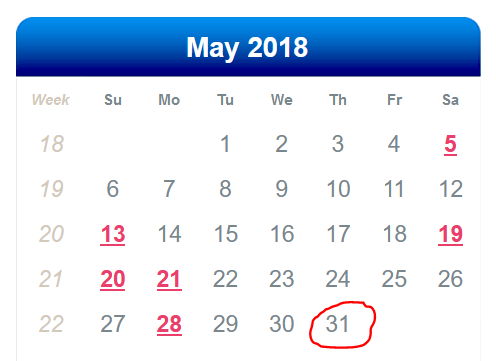
https://www.calendar-365.com/calendar/2018/May.html

In [225]:
print(sticky_df[sticky_df['sf_DAU_by_WAU'] > 99].head())

      Device              End Ts source_id            Start Ts  \
59   desktop 2018-05-31 15:29:00         5 2018-05-31 15:00:00   
275  desktop 2018-05-31 17:50:00         3 2018-05-31 17:44:00   
323  desktop 2018-05-31 15:15:00         3 2018-05-31 15:15:00   
340  desktop 2018-05-31 13:33:00         3 2018-05-31 13:20:00   
458    touch 2018-05-31 12:10:00         2 2018-05-31 12:01:00   

                      Uid  start_day start_week start_month    end_day  \
59   14197660397175580027 2018-05-31 2018-05-31  2018-05-01 2018-05-31   
275  13446604004487566932 2018-05-31 2018-05-31  2018-05-01 2018-05-31   
323  11562693637585843838 2018-05-31 2018-05-31  2018-05-01 2018-05-31   
340    140219665964050675 2018-05-31 2018-05-31  2018-05-01 2018-05-31   
458   1280993306717870348 2018-05-31 2018-05-31  2018-05-01 2018-05-31   

      end_week  end_month   DAU   WAU    MAU  sf_DAU_by_WAU  sf_DAU_by_MAU  
59  2018-05-31 2018-05-01  1997  1997  20701          100.0       9.646877  
275 

In [226]:
print(sticky_df[sticky_df['start_day'] == '2018-05-31'].head(15))

       Device              End Ts source_id            Start Ts  \
59    desktop 2018-05-31 15:29:00         5 2018-05-31 15:00:00   
275   desktop 2018-05-31 17:50:00         3 2018-05-31 17:44:00   
323   desktop 2018-05-31 15:15:00         3 2018-05-31 15:15:00   
340   desktop 2018-05-31 13:33:00         3 2018-05-31 13:20:00   
458     touch 2018-05-31 12:10:00         2 2018-05-31 12:01:00   
710   desktop 2018-05-31 22:37:00         2 2018-05-31 22:20:00   
821   desktop 2018-05-31 14:05:00         2 2018-05-31 14:03:00   
868     touch 2018-05-31 08:34:00         4 2018-05-31 08:34:00   
1238    touch 2018-05-31 22:48:00        10 2018-05-31 22:48:00   
1411    touch 2018-05-31 13:37:00        10 2018-05-31 13:37:00   
1532    touch 2018-05-31 12:12:00         2 2018-05-31 11:55:00   
1553  desktop 2018-05-31 13:22:00         2 2018-05-31 13:16:00   
1603    touch 2018-05-31 09:45:00         4 2018-05-31 09:36:00   
1770    touch 2018-05-31 13:38:00         2 2018-05-31 13:10:0

In [227]:
sticky_df.loc[sticky_df['start_day'] == '2018-05-31', ['sf_DAU_by_WAU']] = np.nan

In [228]:
print(sticky_df[sticky_df['sf_DAU_by_WAU'] > 99].head())

Empty DataFrame
Columns: [Device, End Ts, source_id, Start Ts, Uid, start_day, start_week, start_month, end_day, end_week, end_month, DAU, WAU, MAU, sf_DAU_by_WAU, sf_DAU_by_MAU]
Index: []


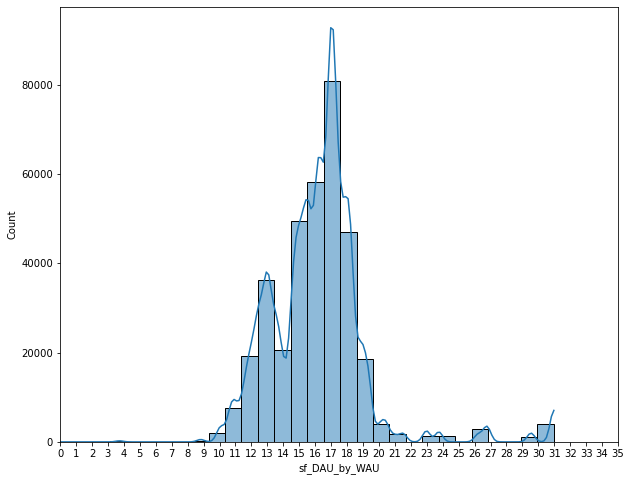

In [229]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = sticky_df, x = "sf_DAU_by_WAU", bins=30, kde=True)
x1 = ax.set_xlim(0,35)
x2 = ax.set_xticks(range(0,36,1))
fig.set_size_inches(10,8)
plt.show()

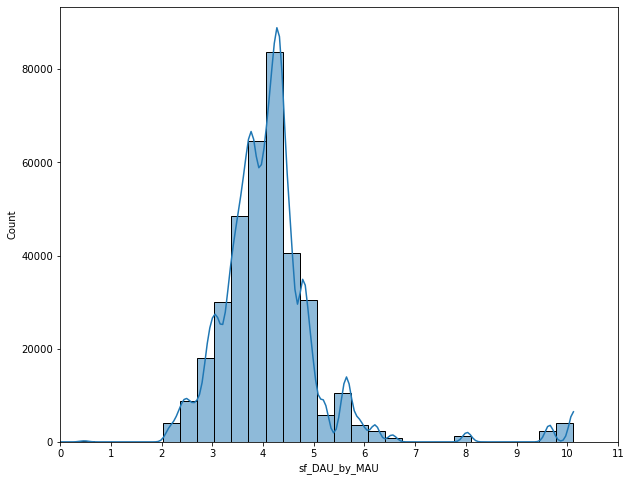

In [230]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = sticky_df, x = "sf_DAU_by_MAU", bins=30, kde=True)
x1 = ax.set_xlim(0,11)
x2 = ax.set_xticks(range(0,12,1))
fig.set_size_inches(10,8)
plt.show()

Let us investigate the sticky factor dynamics:

In [38]:
sf_DAU_by_WAU = sticky_df.groupby(sticky_df['start_week'])['sf_DAU_by_WAU'].mean().reset_index()
sf_DAU_by_MAU = sticky_df.groupby(sticky_df['start_month'])['sf_DAU_by_MAU'].mean().reset_index()

In [39]:
print(sf_DAU_by_WAU.head())
print(sf_DAU_by_MAU.head())

  start_week  sf_DAU_by_WAU
0 2017-06-01      16.301261
1 2017-06-08      17.594904
2 2017-06-15      15.983125
3 2017-06-22      15.798146
4 2017-06-29      16.008730
  start_month  sf_DAU_by_MAU
0  2017-06-01       4.192487
1  2017-07-01       4.172421
2  2017-08-01       3.930491
3  2017-09-01       4.094196
4  2017-10-01       3.868766


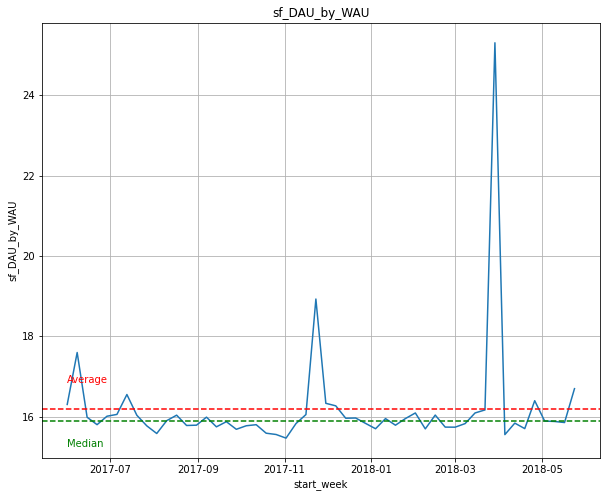

In [236]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'start_week', y = 'sf_DAU_by_WAU',data = sf_DAU_by_WAU)
fig1 = fig.set_size_inches(10,8)
x1 = line_plot.set_title("sf_DAU_by_WAU")
x2 = ax.axhline(sf_DAU_by_WAU.sf_DAU_by_WAU.mean(), ls='--', c='red')
x3 = ax.text(sf_DAU_by_WAU.start_week.min(),1.04 * sf_DAU_by_WAU.sf_DAU_by_WAU.mean(),"Average", c='red')
x4 = ax.axhline(sf_DAU_by_WAU.sf_DAU_by_WAU.median(), ls='--', c='green')
x5 = ax.text(sf_DAU_by_WAU.start_week.min(),0.96 * sf_DAU_by_WAU.sf_DAU_by_WAU.median(),"Median", c='green')
fig99=plt.grid()
plt.show()

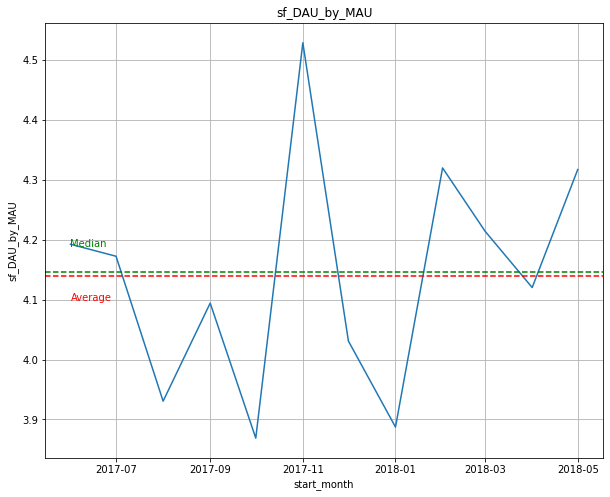

In [237]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'start_month', y = 'sf_DAU_by_MAU',data = sf_DAU_by_MAU)
fig1 = fig.set_size_inches(10,8)
x1 = line_plot.set_title("sf_DAU_by_MAU")
x2 = ax.axhline(sf_DAU_by_MAU.sf_DAU_by_MAU.mean(), ls='--', c='red')
x3 = ax.text(sf_DAU_by_MAU.start_month.min(),0.99 * sf_DAU_by_MAU.sf_DAU_by_MAU.mean(),"Average", c='red')
x4 = ax.axhline(sf_DAU_by_MAU.sf_DAU_by_MAU.median(), ls='--', c='green')
x5 = ax.text(sf_DAU_by_MAU.start_month.min(),1.01 * sf_DAU_by_MAU.sf_DAU_by_MAU.median(),"Median", c='green')
fig99=plt.grid()
plt.show()

Conclusions:
* We can see the visits peek during Nov.-Dec.  
* There is a steep incline between August and November.
* The curve smoothing effect (less changes in values) of taking a longer sampling interval is evident.  
* It appears summer is the low season.
* The spikes in the daily and weekly data suggests there are apparently periodic sales during June and August of the 'dead' period. Trying to boost sales?
* (There may have been a server crash somewhere around april - DAU approaches zero).

These results should not be surpring.  
Yandex.Afisha typically sells tickets to indoor activities - movies, concerts, shows...  
We are supposed to encounter a boost in sales during the cold season.  
https://yandex.com/company/press_center/press_releases/2011/2011-10-12  
https://afisha.yandex.ru/moscow

Investigating the sticky factor, we can see that the majority of users present a stickyness of ~16-17% & ~4% for a week & month period, respectively.  
The periods of increased sticky factor coincide with those of increase in DAU, WAU.
These are reasonable numbers.  
Articles refer to 25% as the gold number (actually it is more like 10-13).  
Also, it is well-established that e-commerce is a low stickiness field (see below)

Good articles can be found here:

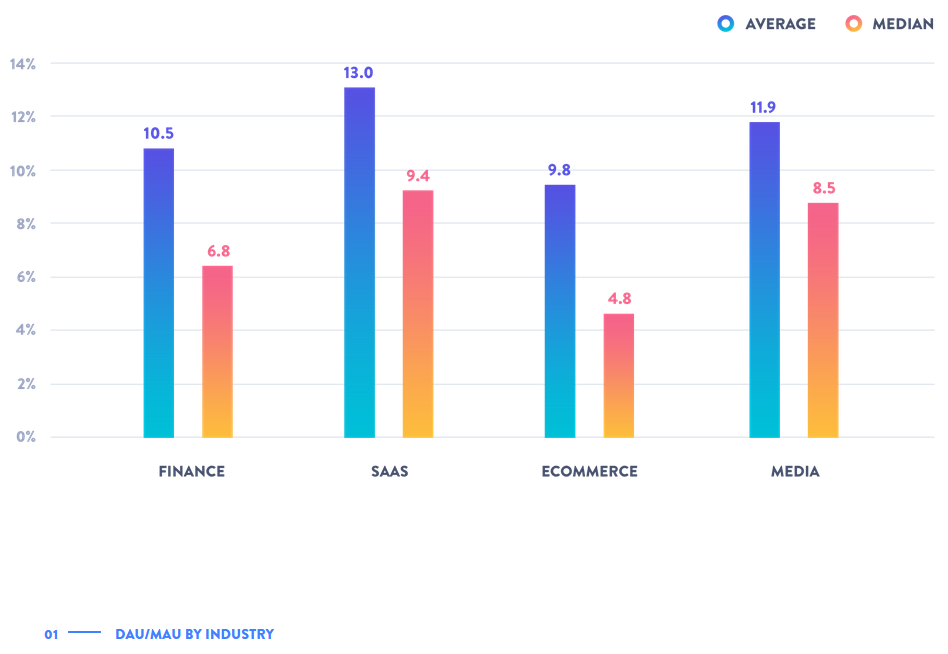
https://mixpanel.com/data-reports/2017-product-benchmarks-report/?utm_medium=affiliate&utm_source=hackernoon&utm_campaign=report&utm_content=2017-product-benchmarks-report&utm_term=full-launch#usage  
https://hackernoon.com/is-there-a-golden-standard-of-stickiness-eafc76708d1

### Sessions vs users

How many sessions are there per day?  
A user might have more than one session.

In [238]:
visits_das = visits.groupby(visits['start_day'])['Uid'].count().reset_index()
visits_was = visits.groupby(visits['start_week'])['Uid'].count().reset_index()
visits_mas = visits.groupby(visits['start_month'])['Uid'].count().reset_index()

In [239]:
visits_das = visits_das.rename(columns={'Uid': 'DAS'}) 
visits_was = visits_was.rename(columns={'Uid': 'WAS'}) 
visits_mas = visits_mas.rename(columns={'Uid': 'MAS'})

In [240]:
print(visits_das.head())
print(visits_das.tail())

print(visits_was.head())
print(visits_was.tail())

print(visits_mas.head())
print(visits_mas.tail())

   start_day  DAS
0 2017-06-01  664
1 2017-06-02  658
2 2017-06-03  477
3 2017-06-04  510
4 2017-06-05  893
     start_day   DAS
359 2018-05-27   672
360 2018-05-28  1156
361 2018-05-29  1035
362 2018-05-30  1410
363 2018-05-31  2256
  start_week   WAS
0 2017-06-01  4865
1 2017-06-08  3813
2 2017-06-15  3255
3 2017-06-22  3509
4 2017-06-29  3538
   start_week   WAS
48 2018-05-03  4795
49 2018-05-10  5545
50 2018-05-17  6275
51 2018-05-24  6721
52 2018-05-31  2256
  start_month    MAS
0  2017-06-01  16505
1  2017-07-01  17828
2  2017-08-01  14355
3  2017-09-01  23907
4  2017-10-01  37903
   start_month    MAS
7   2018-01-01  36939
8   2018-02-01  37182
9   2018-03-01  35679
10  2018-04-01  26515
11  2018-05-01  26635


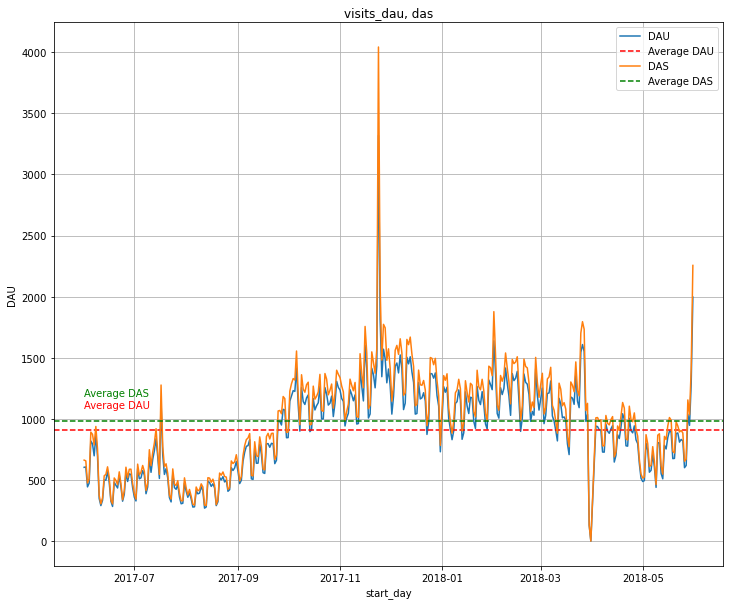

In [248]:
fig, ax = plt.subplots()

line_plot = sns.lineplot(x = 'start_day', y = 'DAU',data = visits_dau)
#fig1 = fig.set_size_inches(10,8)
x11 = line_plot.set_title("visits_dau")
x12 = ax.axhline(visits_dau.DAU.mean(), ls='--', c='red')
x13 = ax.text(visits_dau.start_day.min(),1.2 * visits_dau.DAU.mean(),"Average DAU", c='red')
line_plot2 = sns.lineplot(x = 'start_day', y = 'DAS',data = visits_das)
x21 = line_plot.set_title("visits_dau, das")
x22 = ax.axhline(visits_das.DAS.mean(), ls='--', c='green')
x23 = ax.text(visits_das.start_day.min(),1.2 * visits_das.DAS.mean(),"Average DAS", c='green')
fig1 = fig.set_size_inches(12,10)
gen1 = plt.legend(labels=["DAU", "Average DAU", "DAS", "Average DAS"])
fig99=plt.grid()
plt.show()

In [249]:
DA = pd.merge(visits_dau, visits_das, how='left', on='start_day')

In [250]:
DA ['DA_ratio'] = DA ['DAS'] / DA ['DAU']

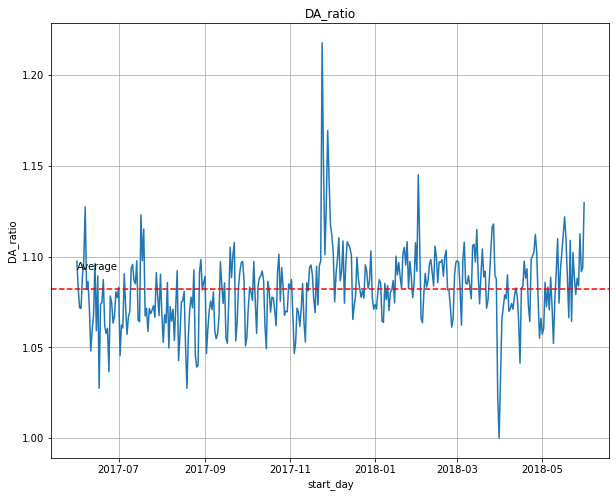

In [251]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'start_day', y = 'DA_ratio',data = DA)
fig1 = fig.set_size_inches(10,8)
x1 = line_plot.set_title("DA_ratio")
x2 = ax.axhline(DA.DA_ratio.mean(), ls='--', c='red')
x3 = ax.text(DA.start_day.min(),1.01 * DA.DA_ratio.mean(),"Average")
fig99=plt.grid()
plt.show()

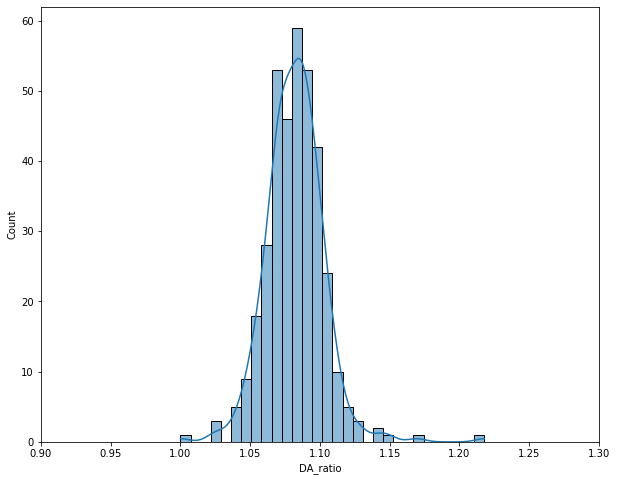

In [252]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = DA, x = "DA_ratio", bins=30, kde=True)
x1 = ax.set_xlim(0.9,1.3)
#x2 = ax.set_xticks(range(0,1.5,0.1))
fig.set_size_inches(10,8)
plt.show()

We can see that there are nearly a 1000 sessions per day.  
Slightly more than the DAU.  
(Obviously, DAS >= DAU - always at least as much sessions as users...)  
So, indeed, some users have more than one session per day.  
But not a lot more, as the ratio is centered around 1.05-1.1, and the graphs are tightly correlated...

### What is the length of each session?

In [253]:
visits['session_length'] = (visits['End Ts'] - visits['Start Ts']) / np.timedelta64(1, 'h')
examine(visits)


***************
 head:
     Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  session_length  
0 2017-12-14 2017-12-01        0.300000  
1 2018-02-15 2018-02-01        0.466667  
2 2017-06-29 2017-07-01        

We can see that we have cases of improper (negative) session length.  
We cannot tell the reason for this error (it is not entries missing from the first day, see below) but obviously session start must precede session end.  
So we will remove these few entries.

In [254]:
print(visits[visits['session_length'] < 0])

         Device              End Ts source_id            Start Ts  \
4181    desktop 2018-03-25 03:18:00         3 2018-03-25 03:50:00   
177972  desktop 2018-03-25 03:09:00         9 2018-03-25 03:55:00   

                         Uid  start_day start_week start_month    end_day  \
4181    13092152539246794986 2018-03-25 2018-03-22  2018-03-01 2018-03-25   
177972   4621202742905035453 2018-03-25 2018-03-22  2018-03-01 2018-03-25   

         end_week  end_month  session_length  
4181   2018-03-22 2018-03-01       -0.533333  
177972 2018-03-22 2018-03-01       -0.766667  


In [255]:
visits.loc[visits['session_length']<0, ['End Ts']] = np.nan
visits.loc[visits['session_length']<0, ['Start Ts']] = np.nan
visits.loc[visits['session_length']<0, ['session_length']] = np.nan
print(visits[visits['session_length'] < 0])

Empty DataFrame
Columns: [Device, End Ts, source_id, Start Ts, Uid, start_day, start_week, start_month, end_day, end_week, end_month, session_length]
Index: []


Remark  
We also have very long sessions (hours).  
These seem in place (or at least, repetitive...).  
They are probably caused due to users forgeting the website open overnight or something like so but we do not know that for sure so we cannot remove this data.

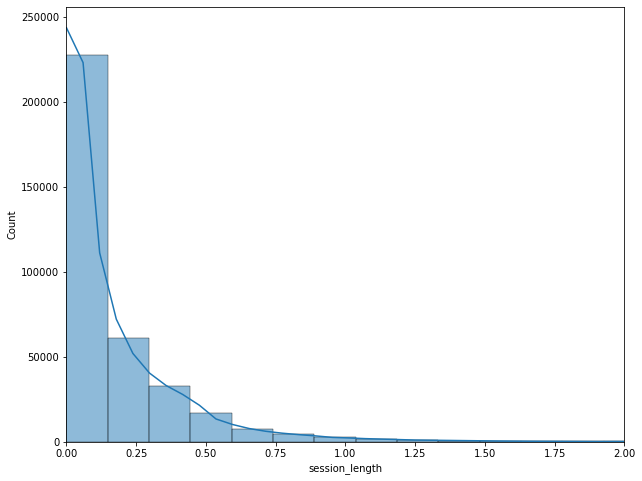

In [256]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = visits, x = "session_length", bins=80, kde=True)
x1 = ax.set_xlim(0,2)
#x2 = ax.set_xticks(range(0,21,1))
fig.set_size_inches(10,8)
plt.show()

In [257]:
examine(visits)


***************
 head:
     Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  session_length  
0 2017-12-14 2017-12-01        0.300000  
1 2018-02-15 2018-02-01        0.466667  
2 2017-06-29 2017-07-01        

We can easily see that most sessions do not exceed a quarter of an hour on average (50% are shorter than 5 min) with very few exceeding one hour.  
The large gap between the mean (0.18 hour) and the median (0.08 hour) indicates that the data is highly skewed. Obviously due to the very long sessions outliers.

### Retention / how often do users come back?

We are looking for retention.  
We will implement a monthly cohort analysis.  
**cohort**: The month when the user registered/had his/her first session.  
**age**: Time difference between current and first sessions (by month).  

These metrics will help us understand:
* How many users (in % out of registered) were active (had sessions) on a certain month after registration/first visit.
* What marketing strategy attracted the users to begin with.
* The differences between users registering on weekday, vacations, weekends, seasons, marketing campaigns vs regular periods etc.
* How are the users responding to a product that is getting older and less attractive or to intermediate marketing strategies/updtaes.
* Seasonality and external factors (competition arriving and so on).

Identify the cohort of each user (first visit)

In [258]:
first_visit=visits.groupby(['Uid'])['start_day'].min().reset_index()
first_visit.columns = ['Uid', 'first_session']
print(first_visit.head())

               Uid first_session
0   11863502262781    2018-03-01
1   49537067089222    2018-02-06
2  297729379853735    2017-06-07
3  313578113262317    2017-09-18
4  325320750514679    2017-09-30


In [259]:
visits = visits.merge(first_visit, how='left', on='Uid')

In [260]:
print(visits.head())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  session_length first_session  
0 2017-12-14 2017-12-01        0.300000    2017-12-20  
1 2018-02-15 2018-02-01        0.466667    2018-02-19  
2 2017-06-29 2

In [261]:
visits['cohort'] = visits['first_session'].astype('datetime64[M]')

In [262]:
print(visits.head())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  session_length first_session     cohort  
0 2017-12-14 2017-12-01        0.300000    2017-12-20 2017-12-01  
1 2018-02-15 2018-02-01        0.466667    2018-

Identify the age of each user (current to first visit)

In [263]:
visits['age'] = ((visits['end_day'] - visits['first_session']) / np.timedelta64(1,'M')).round().astype('int')

In [264]:
print(visits.head())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  session_length first_session     cohort  age  
0 2017-12-14 2017-12-01        0.300000    2017-12-20 2017-12-01    0  
1 2018-02-15 2018-02-01        0.46666

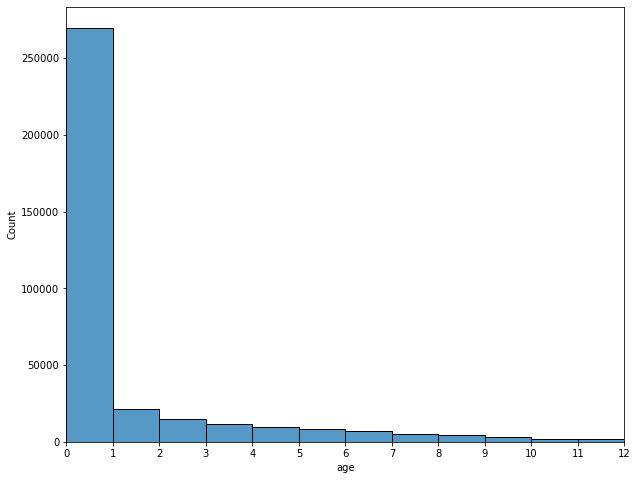

In [265]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = visits, x = "age", bins=12)
x1 = ax.set_xlim(0,12)
x2 = ax.set_xticks(range(0,13,1))
fig.set_size_inches(10,8)
plt.show()

We can clearly see that the majority of visits are performed on the first month (age 0).  
The following months are very low on returning visits.  
(Not surprising and very standard).

Let us see how many users were active from certain cohort at a certain age:

In [266]:
cohorts = visits.pivot_table(index='cohort',
                  columns='age',
                  values='Uid',
                  aggfunc='nunique').fillna(0)

In [267]:
print(cohorts)

age              0       1       2       3      4      5      6      7   \
cohort                                                                    
2017-06-01  13259.0   977.0   718.0   805.0  909.0  892.0  844.0  743.0   
2017-07-01  13140.0   738.0   688.0   699.0  738.0  648.0  587.0  652.0   
2017-08-01  10181.0   702.0   633.0   598.0  517.0  437.0  418.0  350.0   
2017-09-01  16704.0  1263.0  1126.0   816.0  661.0  672.0  552.0  436.0   
2017-10-01  25977.0  1898.0  1376.0   988.0  937.0  816.0  548.0  467.0   
2017-11-01  27248.0  1873.0  1275.0  1044.0  854.0  660.0  504.0   75.0   
2017-12-01  25268.0  1288.0  1037.0   731.0  545.0  414.0   70.0    0.0   
2018-01-01  22624.0  1210.0   821.0   578.0  388.0   44.0    0.0    0.0   
2018-02-01  22197.0  1063.0   596.0   401.0   45.0    0.0    0.0    0.0   
2018-03-01  20589.0   852.0   516.0    76.0    0.0    0.0    0.0    0.0   
2018-04-01  15709.0   622.0    68.0     0.0    0.0    0.0    0.0    0.0   
2018-05-01  15273.0   100

Now we can calculate retention (percentage of registered users at age=0)

In [268]:
retention = cohorts.div(cohorts[0], axis=0)

In [269]:
print(retention)

age          0         1         2         3         4         5         6   \
cohort                                                                        
2017-06-01  1.0  0.073686  0.054152  0.060713  0.068557  0.067275  0.063655   
2017-07-01  1.0  0.056164  0.052359  0.053196  0.056164  0.049315  0.044673   
2017-08-01  1.0  0.068952  0.062175  0.058737  0.050781  0.042923  0.041057   
2017-09-01  1.0  0.075611  0.067409  0.048851  0.039571  0.040230  0.033046   
2017-10-01  1.0  0.073065  0.052970  0.038034  0.036070  0.031412  0.021096   
2017-11-01  1.0  0.068739  0.046792  0.038315  0.031342  0.024222  0.018497   
2017-12-01  1.0  0.050974  0.041040  0.028930  0.021569  0.016384  0.002770   
2018-01-01  1.0  0.053483  0.036289  0.025548  0.017150  0.001945  0.000000   
2018-02-01  1.0  0.047889  0.026850  0.018066  0.002027  0.000000  0.000000   
2018-03-01  1.0  0.041381  0.025062  0.003691  0.000000  0.000000  0.000000   
2018-04-01  1.0  0.039595  0.004329  0.000000  0.000

Let us visualize:

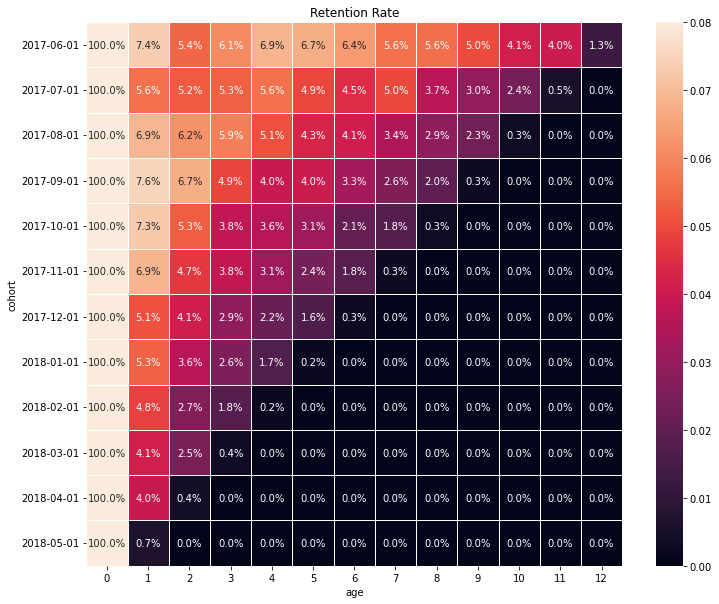

In [270]:
retention.index = retention.index.astype(str)

fig, ax = plt.subplots()

heatmap = sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='white',  vmax=0.08, cbar_kws= {'orientation': 'vertical'} 
            ).set(title = 'Retention Rate')
fig.set_size_inches(12,10)
plt.show()

Cohort analysis shows that:
* Retention rate can reach up to 7-8% during the second month.
* It quite rapidly decreases for the following months.
* Sep./Oct. cohorts had good retention rates for their second month (all across this period diagonal).  
Maybe there was a sale or another bonus deal around that time?  
(Because first and second cohorts also show increased retention for this period... - see diagonal)  
Maybe it is a holiday in Russia?  
The Russian Autumn break is around this time (Oct. end to early Nov.)  
https://www.expatica.com/ru/education/children-education/school-holidays-in-russia-105764/  
Maybe it was black Friday (Nov. 24 2017).  
Though in Russia prices can go up on black Friday, so it is a lower possibility...  
https://weirdrussia.com/2017/11/26/black-friday-2017/  
Whatever happened, it appears effective.  
* The first cohort retention rate is decreasing with the slowest speed.


It is worthwhile to point marketing to the above facts and try to identify what distinguishes the first cohort and mentioned period.  
It may assist sales.  
The every few months spikes are expected because most of us cannot afford tickets to concert or opera or show/musical more than two or three times a year.  
Unfortunately, these tickets are expensive.  
Another reason to go to Yandex course :) ...

### Effect of source id

We saw above that some sources bring much more visits than others (source id 4 vs 6 for instance)

In [271]:
source_df = visits.groupby(visits['source_id'])['Uid'].nunique().reset_index().sort_values('Uid')
source_df = source_df.rename(columns={'Uid': 'unique_users'})

In [272]:
print(source_df)

  source_id  unique_users
6         6             6
7         7            34
1        10          8067
8         9          9264
0         1         18999
2         2         26245
5         5         56974
3         3         74756
4         4         83525


But, how often do users return based on their source_id?

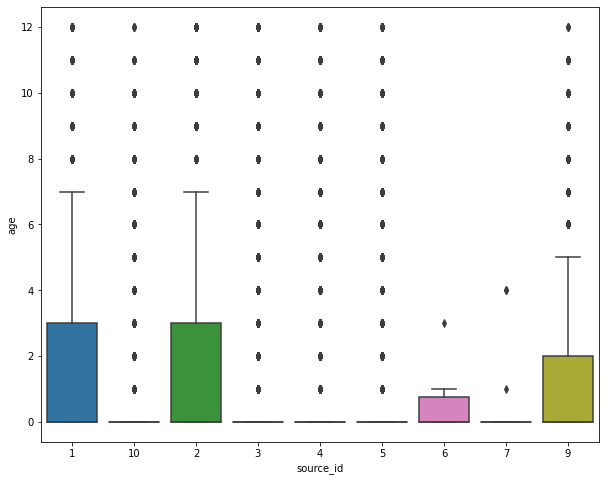

In [273]:
fig, ax = plt.subplots()
box_plot = sns.boxplot(x="source_id", y="age", data=visits)
#swarm_plot = sns.swarmplot(x="source_id", y="age", data=visits, color=".25")
fig.set_size_inches(10,8)
plt.show()

Conclusions:
* Interestingly, the highet providing sources are not necessarily the most stable sources for retention.
* Source 6 provides very few users though they return but it is less of a target.  
* Source 4 (the highest users source) provides nearly no returning users while source 1 provides users that typically return for at least 3 months. The same goes for sources 2 and 9.
* Sources 6/7 do not have outlier retention users that stay as long as a year. These users may be visitors from other countries that come to Russia for a certain season or may just have left Yandex.Afisha altogether for the competition or are research related (time limited).
  
I recommend marketing to investigate what makes users coming from sources 2 and 9 come back more and try implementing these drivers in source 4 users (if possible). This can greatly assist revenue.

## Sales

### Coversion / when do people start buying? 

Conversion depicts how long it takes for users to go from first visit to first purchase (say in days).  

**How to calculate:**
* Use groupby on orders table in order to find the first purchase for each user.
* Define a small new df with users that made purchases and the date of their first order.
* Do the same for visits table to find the first visit (session) for each user (already done).
* Merge the two dataframes together (on Uid) to receive each user first visit and first order.
* Find the difference in days between the first order and first visit.
  
**Why to calculate:**  
* We can compare the conversion patterns of different cohorts.  
* We can determine which cohort, or marketing channel, is most effective.

**Remark:**
* Not all users convert. There can be users with a first visit but no first order. For these users we will not have a first order date (NaT value under first_order column).
* Not all visits are represented in visits table.
* If for some users we have no date of first visit, than it is reasonable to assume that their first order coincides with their first visit and the negative difference should be changed to zero.

In [71]:
first_order=orders.groupby(['Uid'])['Buy Ts'].min().reset_index()
first_order.columns = ['Uid', 'first_order']
first_order['first_order']  = first_order['first_order'].astype('datetime64[D]')

In [72]:
print(first_order.head())

                Uid first_order
0   313578113262317  2018-01-03
1  1575281904278712  2017-06-03
2  2429014661409475  2017-10-11
3  2464366381792757  2018-01-28
4  2551852515556206  2017-11-24


===================================================================================

The following outer merge is intended to check against the left merge that there are no cases of users with orders made that are lacking a first session.  
Results show that there are no such cases.

In [274]:
visits_out = visits.merge(first_order, how='outer', on='Uid')

In [275]:
visits_out[visits_out['first_order'].notnull() & visits_out['first_session'].isna()]

,Device,End Ts,source_id,Start Ts,Uid,start_day,start_week,start_month,end_day,end_week,end_month,session_length,first_session,cohort,age,first_order


In [276]:
print(visits_out.head())
print(visits_out.info())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2018-03-09 20:33:00         4 2018-03-09 20:05:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4  16174680259334210214 2018-03-09 2018-03-08  2018-03-01 2018-03-09   

    end_week  end_month  session_length first_session     cohort  age  \
0 2017-12-14 2017-12-01        0.300000    2017-12-20 2017-12-01    0   
1 2018-02-15 2018-02-01        0.466

==========================================================================

In [277]:
visits = visits.merge(first_order, how='left', on='Uid')

In [278]:
print(visits.head())
print(visits.info())

    Device              End Ts source_id            Start Ts  \
0    touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month    end_day  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   

    end_week  end_month  session_length first_session     cohort  age  \
0 2017-12-14 2017-12-01        0.300000    2017-12-20 2017-12-01    0   
1 2018-02-15 2018-02-01        0.466

In [279]:
visits['conversion']=((visits['first_order'] - visits['first_session']) / np.timedelta64(1,'D'))#.astype('int')

**Remark:**  
astype('int') will not work above because we have nulls in the dataframe column.  
There is an option to define a seperate dataframe and use this dataframe to perform the process, i.e. - work only with the converted users (script below).  
I think this is less preferable because I want to keep the data of cases where we did not receive an order (say for analyzing source_id, unique cohorts trends and so forth in the future).  
The only advantage of this alternative method is that we will get a 'clean' integer.  
This is not possible here because of the nulls.  
However, this is absolutely semantics - we are substracting days and the results will be an integer anyway.  
So I choose to proceed like this.  

In [280]:
print(visits.head(15))

     Device              End Ts source_id            Start Ts  \
0     touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1   desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2     touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3   desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4   desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   
5   desktop 2017-09-03 21:36:00         5 2017-09-03 21:35:00   
6   desktop 2018-01-30 12:09:00         1 2018-01-30 11:13:00   
7     touch 2017-11-05 15:15:00         3 2017-11-05 15:14:00   
8   desktop 2017-07-19 10:44:00         3 2017-07-19 10:41:00   
9   desktop 2017-11-08 13:43:00         5 2017-11-08 13:42:00   
10  desktop 2017-07-14 12:44:00         5 2017-07-14 12:43:00   
11  desktop 2018-01-25 19:41:00         1 2018-01-25 19:37:00   
12  desktop 2018-02-06 15:50:00         4 2018-02-06 15:45:00   
13  desktop 2017-11-27 14:43:00         3 2017-11-27 14:42:00   
14    touch 2018-04-23 18

======================================================================================

The original approach (not used):

In [281]:
conversion = visits.loc[visits.first_order.notnull(), ['Uid', 'first_session','first_order']]
conversion['conversion']=((conversion['first_order'] - conversion['first_session']) / np.timedelta64(1,'D')).astype('int')
print(conversion.head())
print(conversion.info())

                     Uid first_session first_order  conversion
3   16174680259334210214    2018-03-09  2018-03-09           0
5   16007536194108375387    2017-09-03  2017-09-04           1
12   8056418121947262981    2017-06-04  2017-06-25          21
15  18188358787673499603    2018-02-10  2018-02-12           2
25   2307401184189569202    2017-09-23  2017-09-27           4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97394 entries, 3 to 359399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Uid            97394 non-null  uint64        
 1   first_session  97394 non-null  datetime64[ns]
 2   first_order    97394 non-null  datetime64[ns]
 3   conversion     97394 non-null  int32         
dtypes: datetime64[ns](2), int32(1), uint64(1)
memory usage: 3.3 MB
None


In [282]:
print(visits.conversion.describe())

count    97394.000000
mean        33.713750
std         63.348208
min          0.000000
25%          0.000000
50%          1.000000
75%         37.000000
max        363.000000
Name: conversion, dtype: float64


======================================================================================

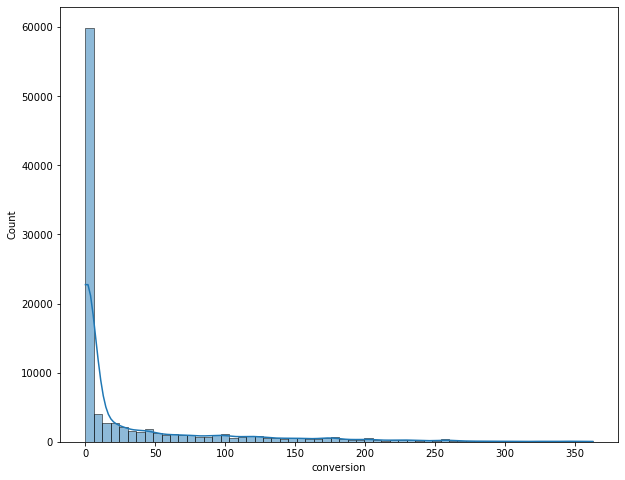

In [283]:
fig, ax = plt.subplots()
hisplot = sns.histplot(data = visits, x = "conversion", bins=60, kde=True)
fig.set_size_inches(10,8)
plt.show()

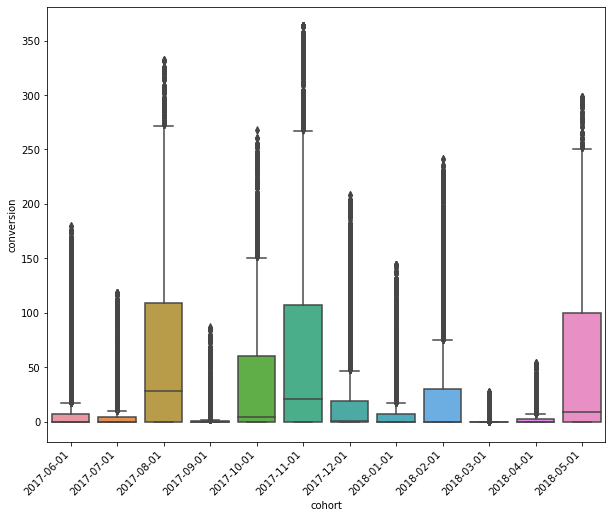

In [284]:
fig, ax = plt.subplots()
box_plot = sns.boxplot(x="cohort", y="conversion", data=visits)
x_dates = visits.cohort.dt.strftime('%Y-%m-%d').sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
fig.set_size_inches(10,8)
plt.show()

#https://stackoverflow.com/questions/51105648/ordering-and-formatting-dates-on-x-axis-in-seaborn-bar-plot

Let us investigate the source effect:

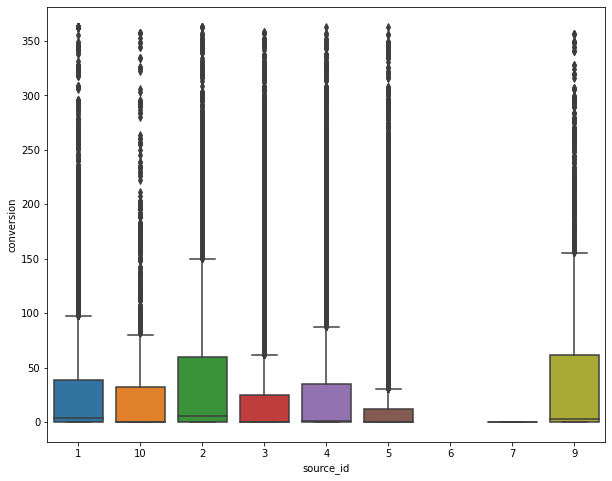

In [285]:
fig, ax = plt.subplots()
box_plot = sns.boxplot(x="source_id", y="conversion", data=visits)
fig.set_size_inches(10,8)
plt.show()

Overall orders:

In [286]:
overall_order = visits.loc[visits['first_order'].notnull(), ['Uid']].nunique() / visits.loc[visits['first_session'].notnull(), ['Uid']].nunique() * 100
print(overall_order)

Uid    16.006995
dtype: float64


We have an overall order rate of 16%.  
This is very respectable.  
It is probably because when people log on to Yandex Afisha, many already know what they want and intend to buy.

**Conclusions:**  
* 16% of visitors eventually convert.
* 50% of the people who convert (buyers) do so within a day (same or the next day) following their first visit to Yandex afisha.  
* Less than 25% return to make orders after more than 37 days.  
* This means that Yandex afisha does not have a large 'regular' customers baseline.  
Users come in when they wish to order something and then they typically leave.  
It is a short dynamics operation.  
You go online typically knowing in advance what you want.  
This agrees with what we saw before (cohort analysis, retention and so forth and the high price of tickets...).
* There is a considerable difference in the conversion distribution between cohorts.  
Aug., Nov, and May cohorts have a very large conversion distribution while the other months have very small (short) conversion intervals. This means that the latter months users orderd very close to their joining date.  
Maybe they had flash deals?  
Also, perhaps Aug., Nov, and May provide tickets to prime shows that do not have flash deals or that require registration a lot of time ahead or just waiting in line for spare / last minute cheap seats?
* The only cohort presenting sessions above 350 days is Nov. 2017.  
Maybe people joined another Yandex product or afisha the previous year and did not buy anything until the next year black friday or another deal period?
* Sources 2 and 9 present the longest conversion period and source id 5 presents the shortest conversion period.  
Maybe source 5 is dedicated to flash deals / discounts or some other short window offers or a temporary study?  
* Sources 6 & 7 yield nearly no conversions.
* In general, it is interesting to note that cohort may prove a better predictor of conversion time than source because conversion intervals for cohorts easily span up to even a 100 days for the IQR (Inter Quartile Range) while they only span much less (generally up to ~50 days) for the source parameter.

### How many orders do they make during a given period of time?

Here, we are asked to perform a cohort analysis for the orders.  

**Why:**  
* This makes sense because orders dynamics is not necessarily visits dynamics.  
We would like to see any potential differences.  
For example, a marketing campaign can attract a lot of visitors but they will not convert (empty users).  
This will tell us a lot about the marketing strategy efficiency.  
What made the user purchase rather than visit? (a deal, a technical upgrade of the website, an attractive show?...)
* The orders No. will always increase but does it coincide with the visits?  
Maybe we have less and less customers but those remaining are the more loyal ordering ones (we know this is hardly the case at Yandex Afisha, it is just an example...)?  
* Marketing success is based on buyers (orders and returns), not on visitors.  
* Later, we will use this data for LTV, CAC and ROMI calculations.  

**How:**  
* Define the cohort for each buyer.
* Aggregate the data.
* For each cohort, calculate the number of purchases and buyers as a function of age (months).  
* The resulting data will be presented using a pivot table.

Remark:  
Since Yandex Afisha users present a very low (fast) conversion rate, it is quite reasonable that there will be close similarity between visits and orders cohort trends. 

Let us define the order cohort:

In [287]:
orders = orders.merge(first_order, how='left', on='Uid')

In [288]:
print(orders.head())

               Buy Ts  Revenue                   Uid    buy_day   buy_week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-06-01   

   buy_month first_order  
0 2017-06-01  2017-06-01  
1 2017-06-01  2017-06-01  
2 2017-06-01  2017-06-01  
3 2017-06-01  2017-06-01  
4 2017-06-01  2017-06-01  


In [289]:
orders['order_cohort'] = orders['first_order'].astype('datetime64[M]')

In [290]:
print(orders.tail(5))

                   Buy Ts  Revenue                   Uid    buy_day  \
50410 2018-05-31 23:50:00     4.64  12296626599487328624 2018-05-31   
50411 2018-05-31 23:50:00     5.80  11369640365507475976 2018-05-31   
50412 2018-05-31 23:54:00     0.30   1786462140797698849 2018-05-31   
50413 2018-05-31 23:56:00     3.67   3993697860786194247 2018-05-31   
50414 2018-06-01 00:02:00     3.42     83872787173869366 2018-06-01   

        buy_week  buy_month first_order order_cohort  
50410 2018-05-31 2018-05-01  2018-05-31   2018-05-01  
50411 2018-05-31 2018-05-01  2018-05-31   2018-05-01  
50412 2018-05-31 2018-05-01  2018-05-31   2018-05-01  
50413 2018-05-31 2018-05-01  2018-05-31   2018-05-01  
50414 2018-05-31 2018-06-01  2018-06-01   2018-06-01  


Now we can aggregate data.  
First, the cohort size:

In [291]:
cohort_sizes = orders.groupby('order_cohort').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns=['order_cohort','cohort_size']

In [292]:
print(cohort_sizes)

   order_cohort  cohort_size
0    2017-06-01         2023
1    2017-07-01         1923
2    2017-08-01         1370
3    2017-09-01         2581
4    2017-10-01         4340
5    2017-11-01         4081
6    2017-12-01         4383
7    2018-01-01         3373
8    2018-02-01         3651
9    2018-03-01         3533
10   2018-04-01         2276
11   2018-05-01         2988
12   2018-06-01            1


Not surprisingly, Oct. - Dec. cohorts convert the most.  
This is the season when people stay indoors and use Yandex Afisha services.  
It is probably not Jan-Feb because tickets need to be ordered in advance...

============================================================================

Remark:  
We are now receiving an additional cohort - June 2018 that was not present for the visits dataframe.  
When I calculated visits I took the session start as the determing timestamp for the visit start and not the session end.  
This is because a visitor starting a session late at night and moving a day forward should be counted as an overnight session (day 1 and not day 0).  
Here, we fall upon just such a case of a purchase being made a day after the session start.  
Thought the session lasts only 5 minutes (see below), the conversion will remain one day as we are counting dates and not absolute durations.  
This calculation approach is in the heart of cohort analysis as we perform it.  
We can replace the time to absolute since visit but than division to cohort months becomes null and we need to go back and define custom groups.  
Therefore, we should accept this caveat of the technique and be aware of it.

In [293]:
visits[visits['first_order'] == '2018-06-01']

,Device,End Ts,source_id,Start Ts,Uid,start_day,start_week,start_month,end_day,end_week,end_month,session_length,first_session,cohort,age,first_order,conversion
299620,desktop,2018-06-01 00:04:00,4,2018-05-31 23:59:00,83872787173869366,2018-05-31,2018-05-31,2018-05-01,2018-06-01,2018-05-31,2018-06-01,0.083333,2018-05-31,2018-05-01,0,2018-06-01,1.0


============================================================================

Now we will calculate the following orders of each cohort:  
(How many orders and on what following months)

In [294]:
cohort_ord = orders.groupby(['order_cohort','buy_month'])['Revenue'].count().reset_index()
cohort_ord.columns=['order_cohort','buy_month','orders_num']

In [295]:
print(cohort_ord)

   order_cohort  buy_month  orders_num
0    2017-06-01 2017-06-01        2354
1    2017-06-01 2017-07-01         177
2    2017-06-01 2017-08-01         174
3    2017-06-01 2017-09-01         226
4    2017-06-01 2017-10-01         292
5    2017-06-01 2017-11-01         218
6    2017-06-01 2017-12-01         276
7    2017-06-01 2018-01-01         174
8    2017-06-01 2018-02-01         212
9    2017-06-01 2018-03-01         153
10   2017-06-01 2018-04-01          96
11   2017-06-01 2018-05-01          86
12   2017-07-01 2017-07-01        2186
13   2017-07-01 2017-08-01         100
14   2017-07-01 2017-09-01         120
15   2017-07-01 2017-10-01         104
16   2017-07-01 2017-11-01          72
17   2017-07-01 2017-12-01          82
18   2017-07-01 2018-01-01          61
19   2017-07-01 2018-02-01          50
20   2017-07-01 2018-03-01          58
21   2017-07-01 2018-04-01          24
22   2017-07-01 2018-05-01          53
23   2017-08-01 2017-08-01        1533
24   2017-08-01 2017-09-0

Merging back with cohort_sizes:

In [296]:
cohort_ord = cohort_ord.merge(cohort_sizes, how='left', on=['order_cohort'])

Calculating orders age:

In [297]:
cohort_ord['age'] = ((cohort_ord['buy_month'] - cohort_ord['order_cohort']) / np.timedelta64(1,'M')).round()

Calculating average orders per user:

In [298]:
cohort_ord['orders_per_buyer'] = cohort_ord['orders_num'] / cohort_ord['cohort_size']

In [299]:
print(cohort_ord)

   order_cohort  buy_month  orders_num  cohort_size   age  orders_per_buyer
0    2017-06-01 2017-06-01        2354         2023   0.0          1.163618
1    2017-06-01 2017-07-01         177         2023   1.0          0.087494
2    2017-06-01 2017-08-01         174         2023   2.0          0.086011
3    2017-06-01 2017-09-01         226         2023   3.0          0.111715
4    2017-06-01 2017-10-01         292         2023   4.0          0.144340
5    2017-06-01 2017-11-01         218         2023   5.0          0.107761
6    2017-06-01 2017-12-01         276         2023   6.0          0.136431
7    2017-06-01 2018-01-01         174         2023   7.0          0.086011
8    2017-06-01 2018-02-01         212         2023   8.0          0.104795
9    2017-06-01 2018-03-01         153         2023   9.0          0.075630
10   2017-06-01 2018-04-01          96         2023  10.0          0.047454
11   2017-06-01 2018-05-01          86         2023  11.0          0.042511
12   2017-07

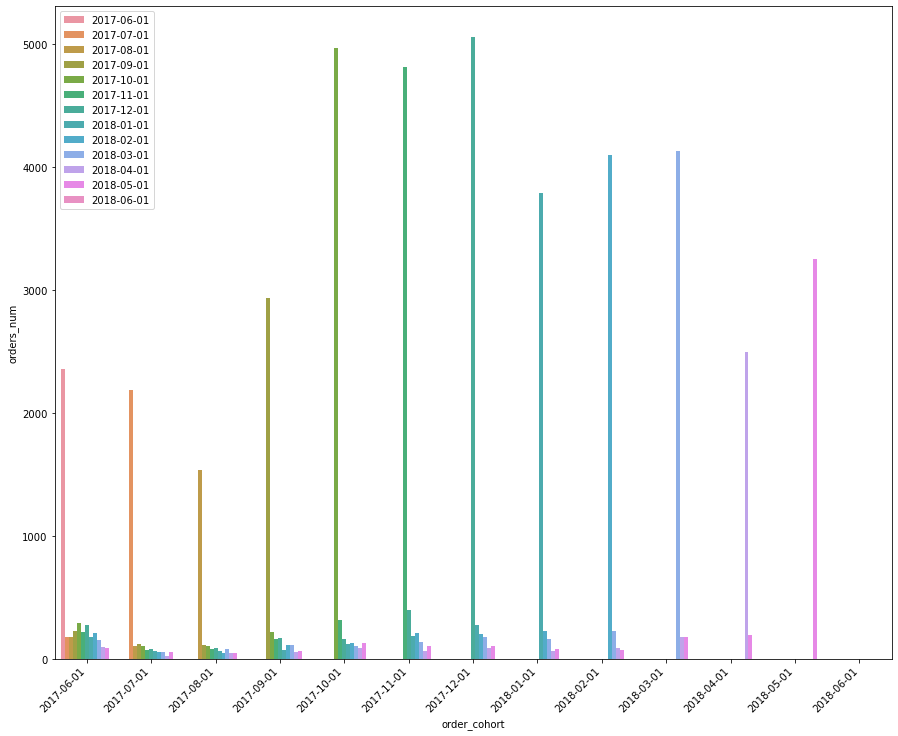

In [300]:
# Draw a nested barplot by cohort and month
fig, ax = plt.subplots()
l_dates = cohort_ord.buy_month.dt.strftime('%Y-%m-%d').sort_values().unique()
box_plot = sns.barplot(x = cohort_ord["order_cohort"],
                       y = cohort_ord["orders_num"],
                       hue = "buy_month",
                       hue_order=l_dates,
                       data= cohort_ord)          
x_dates = cohort_ord.order_cohort.dt.strftime('%Y-%m-%d').sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
fig.set_size_inches(15,12)
plt.show()

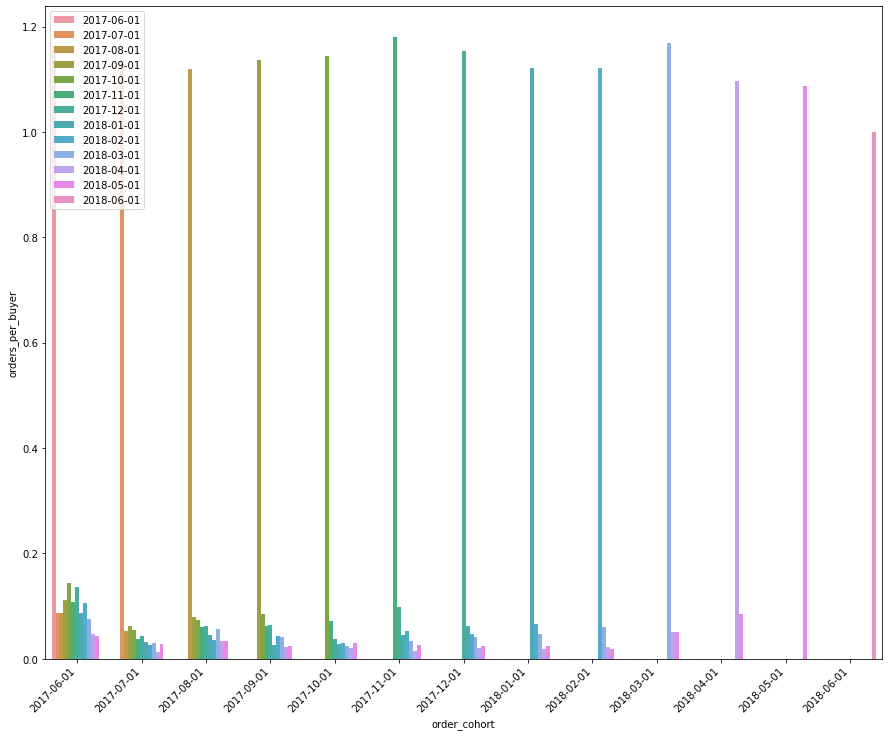

In [301]:
# Draw a nested barplot by cohort and month
fig, ax = plt.subplots()
l_dates = cohort_ord.buy_month.dt.strftime('%Y-%m-%d').sort_values().unique()
box_plot = sns.barplot(x = cohort_ord["order_cohort"],
                       y = cohort_ord["orders_per_buyer"],
                       hue = "buy_month",
                       hue_order=l_dates,
                       data= cohort_ord)          
x_dates = cohort_ord.order_cohort.dt.strftime('%Y-%m-%d').sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
fig.set_size_inches(15,12)
plt.show()

Let's present the data again in the customary pivot table (with and without cumsum):

In [302]:
cohorts_ord_piv = cohort_ord.pivot_table(index='order_cohort',
                  columns='age',
                  values='orders_per_buyer',
                  aggfunc='sum').round(2).fillna('')#.fillna(0)

In [303]:
print(cohorts_ord_piv)

age           0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
order_cohort                                                               
2017-06-01    1.16  0.09  0.09  0.11  0.14  0.11  0.14  0.09   0.1  0.08   
2017-07-01    1.14  0.05  0.06  0.05  0.04  0.04  0.03  0.03  0.03  0.01   
2017-08-01    1.12  0.08  0.07  0.06  0.06  0.05  0.04  0.06  0.03  0.03   
2017-09-01    1.14  0.08  0.06  0.06  0.03  0.04  0.04  0.02  0.02         
2017-10-01    1.14  0.07  0.04  0.03  0.03  0.02  0.02  0.03               
2017-11-01    1.18   0.1  0.04  0.05  0.03  0.01  0.02                     
2017-12-01    1.15  0.06  0.05  0.04  0.02  0.02                           
2018-01-01    1.12  0.07  0.05  0.02  0.02                                 
2018-02-01    1.12  0.06  0.02  0.02                                       
2018-03-01    1.17  0.05  0.05                                             
2018-04-01    1.10  0.09                                                   
2018-05-01  

In [304]:
cohorts_ord_cum_piv = cohort_ord.pivot_table(index='order_cohort',
                  columns='age',
                  values='orders_per_buyer',
                  aggfunc='sum').cumsum(axis=1).round(2).fillna('')#.fillna(0)

In [305]:
print(cohorts_ord_cum_piv)

age           0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
order_cohort                                                               
2017-06-01    1.16  1.25  1.34  1.45  1.59   1.7  1.84  1.92  2.03   2.1   
2017-07-01    1.14  1.19  1.25  1.31  1.34  1.39  1.42  1.44  1.47  1.49   
2017-08-01    1.12   1.2  1.27  1.33  1.39  1.44  1.47  1.53  1.56   1.6   
2017-09-01    1.14  1.22  1.28  1.35  1.37  1.42  1.46  1.48   1.5         
2017-10-01    1.14  1.22  1.25  1.28  1.31  1.34  1.35  1.38               
2017-11-01    1.18  1.28  1.32  1.37  1.41  1.42  1.45                     
2017-12-01    1.15  1.21  1.26   1.3  1.32  1.34                           
2018-01-01    1.12  1.19  1.24  1.25  1.28                                 
2018-02-01    1.12  1.18  1.21  1.22                                       
2018-03-01    1.17  1.22  1.27                                             
2018-04-01    1.10  1.18                                                   
2018-05-01  

Let us visualize:

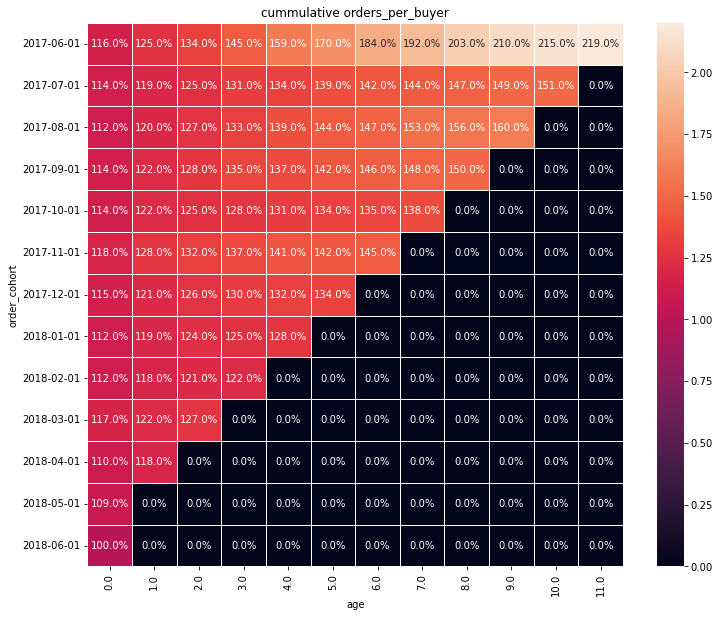

In [307]:
cohorts_ord_cum_piv = cohort_ord.pivot_table(index='order_cohort',
                  columns='age',
                  values='orders_per_buyer',
                  aggfunc='sum').cumsum(axis=1).round(2).fillna(0)

cohorts_ord_cum_piv.index = cohorts_ord_cum_piv.index.astype(str)

fig, ax = plt.subplots()
heatmap = sns.heatmap(cohorts_ord_cum_piv, annot=True, fmt='.1%', linewidths=1, linecolor='white',  vmax=2.2, cbar_kws= {'orientation': 'vertical'} 
            ).set(title = 'cummulative orders_per_buyer')
fig.set_size_inches(12,10)
plt.show()


Orders cohort analysis demonstrates that:  
* It is very clear that users perform the majority of their orders on their first month.  
After that, it takes them almost a year to double their orders (reach 2 orders per users cummulatively).  
* While Oct-Dec cohorts are much larger (2-3 times June-Aug. cohorts), their orders per buyer are not very different.  
* Yandex Afisha marketing should target attracting more visitors because the visitors promptly convert and at a very constant orders per user ratio. Trying to attract users to perform recurring purchases appears to be a lower and much slower option...
This is very important for marketing to know as they pay money upfront - for the initial cohort size (to attract the customers). They should therefore assume that these are largely one timers. Then they can predict what monthly expenses can the buisness accomodate and still remain profitable.  
* In the long run - the June cohort is the most profitable and the July and Oct. cohorts are the weakest. Marketing should particularly pay attention to the latter cohorts.

### What is the average purchase size?

Here we are looking for the average order, ARRPU and the average check (orders per user).

In [106]:
orders['Revenue'].mean()

4.999646930476993

The overall average Revenue is 5.  
It is probably recorded in U.S. dollars and not in rubles because:
1. 5 U.S. dollars are ~ 380 Rubles today (see online converters)
2. Yandex Afisha website publishes prime shows that can cost around 1500 - 3500 Rubles (see below).  
So it is quite logical that the average price for movies or other (cheaper) events will be around few hundred rubles.

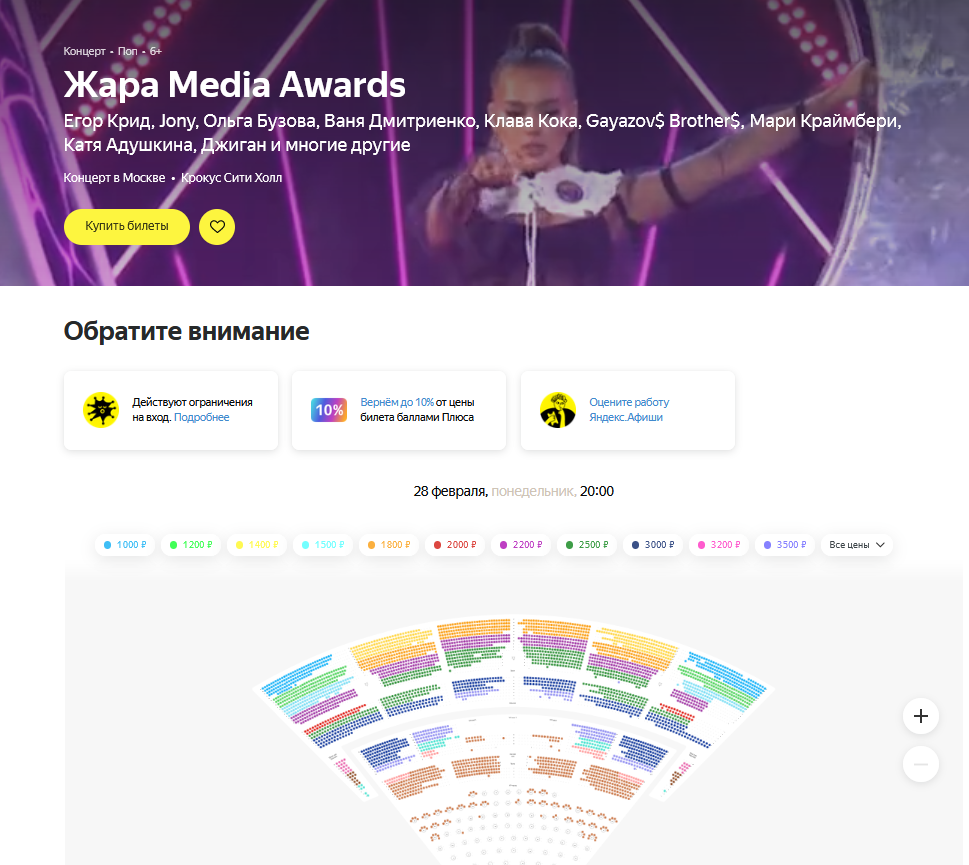
https://afisha.yandex.ru/moscow/concert/zhara-media-awards?source=selection-events

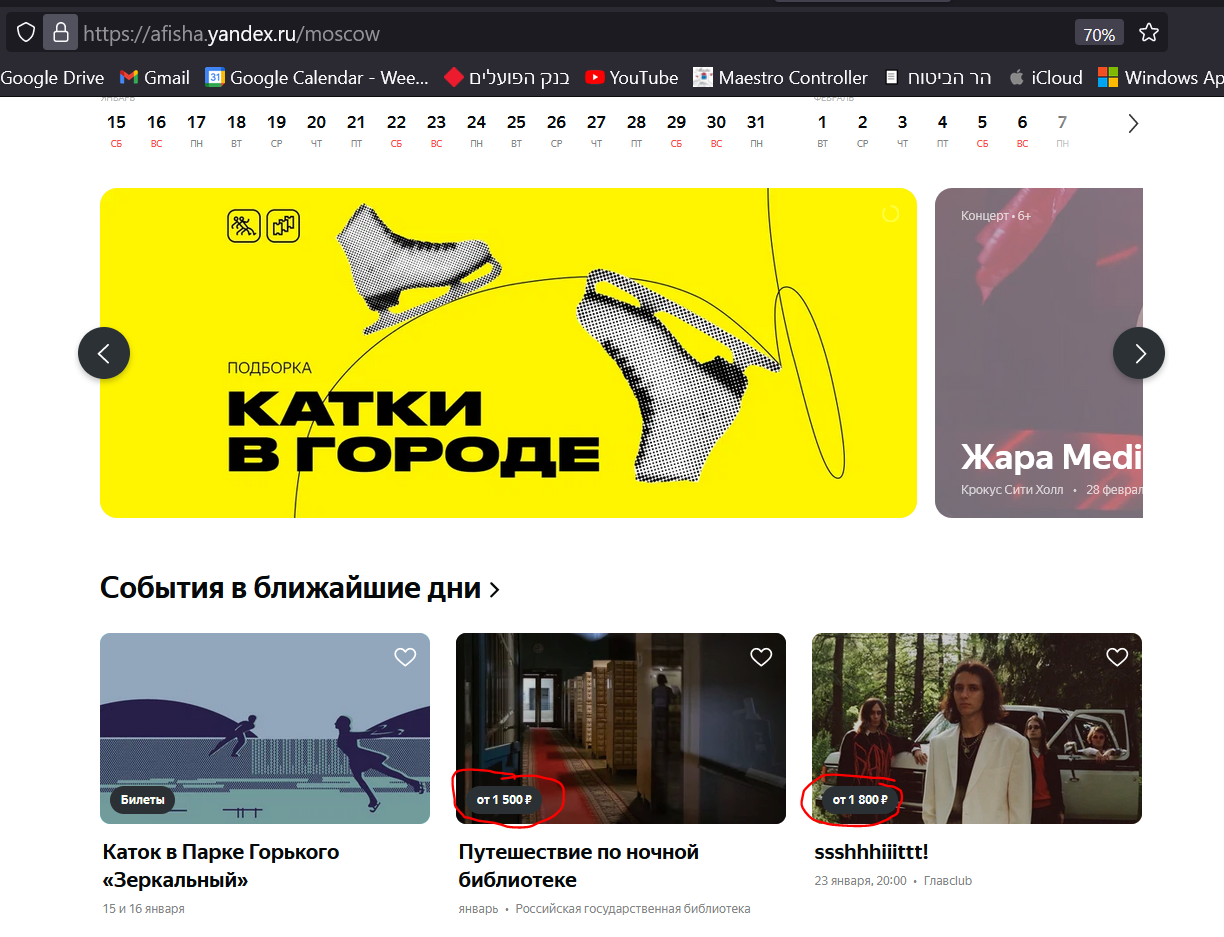

**Average Revenue Per Paying User:**

In [308]:
ARPPU = orders.groupby(['Uid'])['Revenue'].sum().reset_index()

In [309]:
examine(ARPPU)


***************
 head:
                 Uid  Revenue
0   313578113262317     0.55
1  1575281904278712     3.05
2  2429014661409475    73.33
3  2464366381792757     2.44
4  2551852515556206    10.99

***************
 tail:
                         Uid  Revenue
36518  18445147675727495770     3.05
36519  18445407535914413204     0.88
36520  18445601152732270159     4.22
36521  18446156210226471712     9.78
36522  18446167067214817906     7.94
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Uid      36523 non-null  uint64 
 1   Revenue  36523 non-null  float64
dtypes: float64(1), uint64(1)
memory usage: 570.8 KB

***************
 info:
 None

***************
 describe:
                 Uid       Revenue
count  3.652300e+04  36523.000000
mean   9.213152e+18      6.901328
std    5.324792e+18     88.128535
min    3.135781e+14      0.000000
25%    4.615

**Average Check:**

In [310]:
avg_check = orders.groupby(['Uid'])['Revenue'].mean().reset_index()

In [311]:
examine(avg_check)


***************
 head:
                 Uid  Revenue
0   313578113262317    0.550
1  1575281904278712    1.525
2  2429014661409475   73.330
3  2464366381792757    2.440
4  2551852515556206    5.495

***************
 tail:
                         Uid   Revenue
36518  18445147675727495770  3.050000
36519  18445407535914413204  0.293333
36520  18445601152732270159  4.220000
36521  18446156210226471712  9.780000
36522  18446167067214817906  7.940000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Uid      36523 non-null  uint64 
 1   Revenue  36523 non-null  float64
dtypes: float64(1), uint64(1)
memory usage: 570.8 KB

***************
 info:
 None

***************
 describe:
                 Uid       Revenue
count  3.652300e+04  36523.000000
mean   9.213152e+18      4.093093
std    5.324792e+18      7.671220
min    3.135781e+14      0.000000
25%   

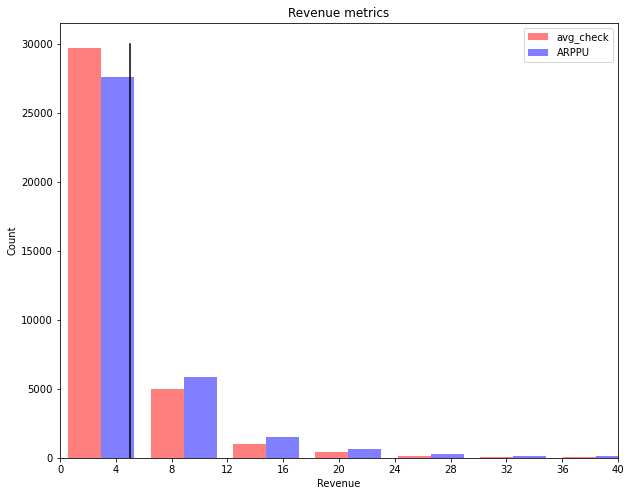

In [312]:
fig, ax = plt.subplots()
x0 = plt.hist([avg_check['Revenue'], ARPPU['Revenue']], color=['r','b'], bins=2000, alpha=0.5)
x1 = ax.set_xlim(0,40)
x2 = ax.set_xticks(range(0,44,4))
x3 = ax.set_title('Revenue metrics')
x4 = ax.set_xlabel('Revenue')
x5 = ax.set_ylabel('Count')
fig1 = plt.legend(labels=['avg_check', 'ARPPU'])
fig2 = plt.plot([orders['Revenue'].mean(), orders['Revenue'].mean()],
                [0, 30000], color = 'black')
fig.set_size_inches(10,8)
plt.show()

We can see that:
* Most avg_check and ARRPU values are below the overall Revenue per order (Revenue per row, black vertical line above) - this is because of the few very high orders outliers.  
It is expected because most people buy movie tickets or cheap daily products, not premium seats for leading shows.
* More than 50% of ARRPU are priced below 3.05 dollars.
* More than 50% of average checks are priced below 2.5 dollars.  
This is quite logical as Average check ≤ ARPPU (known and visible in histogram above).

Cohort analysis on averge check:

In [313]:
avg_order_cohort = orders.groupby(['order_cohort','buy_month'])['Revenue'].mean().reset_index()
avg_order_cohort['age'] = ((avg_order_cohort['buy_month'] - avg_order_cohort['order_cohort']) / np.timedelta64(1,'M')).round()

In [314]:
avg_order_cohort

,order_cohort,buy_month,Revenue,age
0,2017-06-01,2017-06-01,4.060106,0.0
1,2017-06-01,2017-07-01,5.547006,1.0
2,2017-06-01,2017-08-01,5.088161,2.0
3,2017-06-01,2017-09-01,8.545575,3.0
4,2017-06-01,2017-10-01,7.084178,4.0
5,2017-06-01,2017-11-01,6.825321,5.0
6,2017-06-01,2017-12-01,6.966449,6.0
7,2017-06-01,2018-01-01,6.761839,7.0
8,2017-06-01,2018-02-01,5.279009,8.0
9,2017-06-01,2018-03-01,8.009869,9.0


In [315]:
avg_order_cohort_piv = avg_order_cohort.pivot_table(
    index='order_cohort', 
    columns='age', 
    values='Revenue', 
    aggfunc='mean'
).round(2).fillna('')

In [316]:
print(avg_order_cohort_piv)

age           0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0   8.0   \
order_cohort                                                                
2017-06-01    4.06   5.55   5.09   8.55   7.08   6.83   6.97   6.76  5.28   
2017-07-01    5.29   6.45   9.99   6.64   4.72   3.66   3.79   5.45  5.35   
2017-08-01    4.72   5.99   6.28   6.62   7.96   6.27   5.89   7.11   8.7   
2017-09-01    4.97  13.17   8.35  62.57  15.43  15.32  16.77  11.21  7.79   
2017-10-01    4.37   7.41   5.13   5.59    5.1   5.07   4.28   4.01         
2017-11-01    4.37    4.1   4.47   6.28   4.44   3.73    4.6                
2017-12-01    4.11   4.23  20.07  26.08  15.95  14.11                       
2018-01-01    3.69   4.44   6.45   7.52   2.71                              
2018-02-01    3.71   4.58   3.45   3.87                                     
2018-03-01    4.14   5.97   6.33                                            
2018-04-01    4.25    6.2                                                   

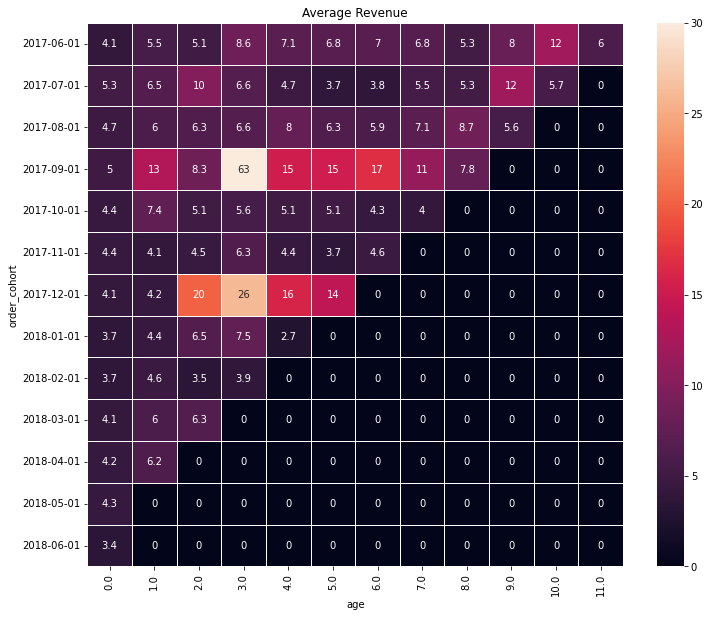

In [317]:
avg_order_cohort_piv = avg_order_cohort.pivot_table(
    index='order_cohort', 
    columns='age', 
    values='Revenue', 
    aggfunc='mean'
).round(2).fillna(0)

avg_order_cohort_piv.index = avg_order_cohort_piv.index.astype(str)

fig, ax = plt.subplots()
heatmap = sns.heatmap(avg_order_cohort_piv, annot=True, linewidths=1, linecolor='white',  vmax=30, cbar_kws= {'orientation': 'vertical'} 
            ).set(title = 'Average Revenue')
fig.set_size_inches(12,10)
plt.show()


We can see that:
* Changes in average Revenue are generally moderate because the products do not considerably vary. They remain movies, shows...
* In terms of average order, the Sep. and Dec. cohorts considerably outperform the other cohorts.
* For these cohorts, the fourth month (age = 3) is considerably more profitable than the other months.
* The Sep. cohort present very high revenue for the fourth month. Maybe Christmas (Novi God) sales? Marketing should investigate. It does agree with the best months above...

### How much money do they bring? (LTV)

Here we calculate revenue per user.  
LTV shows the amount of money each buyer generated over time.  
Let us assume margin rate = 1 (not realistic but we have no other concrete information...), so:
gross profit = revenue x margin rate = revenue

Get revenue per cohort per month:

In [320]:
ltv = orders.groupby(['order_cohort','buy_month'])['Revenue'].sum().reset_index()
ltv.columns = ['order_cohort','buy_month','Revenue']

Merge with cohort_sizes dataframe (so we can normalize by cohort size):

In [321]:
ltv=ltv.merge(cohort_sizes,on=['order_cohort'])
ltv['age']=((ltv['buy_month'] - ltv['order_cohort']) / np.timedelta64(1,'M')).round()
ltv['ltv']=ltv['Revenue'] / ltv['cohort_size'] #should be times margin rate here...

In [322]:
print(ltv)

   order_cohort  buy_month   Revenue  cohort_size   age       ltv
0    2017-06-01 2017-06-01   9557.49         2023   0.0  4.724414
1    2017-06-01 2017-07-01    981.82         2023   1.0  0.485329
2    2017-06-01 2017-08-01    885.34         2023   2.0  0.437637
3    2017-06-01 2017-09-01   1931.30         2023   3.0  0.954671
4    2017-06-01 2017-10-01   2068.58         2023   4.0  1.022531
5    2017-06-01 2017-11-01   1487.92         2023   5.0  0.735502
6    2017-06-01 2017-12-01   1922.74         2023   6.0  0.950440
7    2017-06-01 2018-01-01   1176.56         2023   7.0  0.581592
8    2017-06-01 2018-02-01   1119.15         2023   8.0  0.553213
9    2017-06-01 2018-03-01   1225.51         2023   9.0  0.605788
10   2017-06-01 2018-04-01   1155.66         2023  10.0  0.571261
11   2017-06-01 2018-05-01    519.62         2023  11.0  0.256856
12   2017-07-01 2017-07-01  11557.65         1923   0.0  6.010218
13   2017-07-01 2017-08-01    644.61         1923   1.0  0.335211
14   2017-

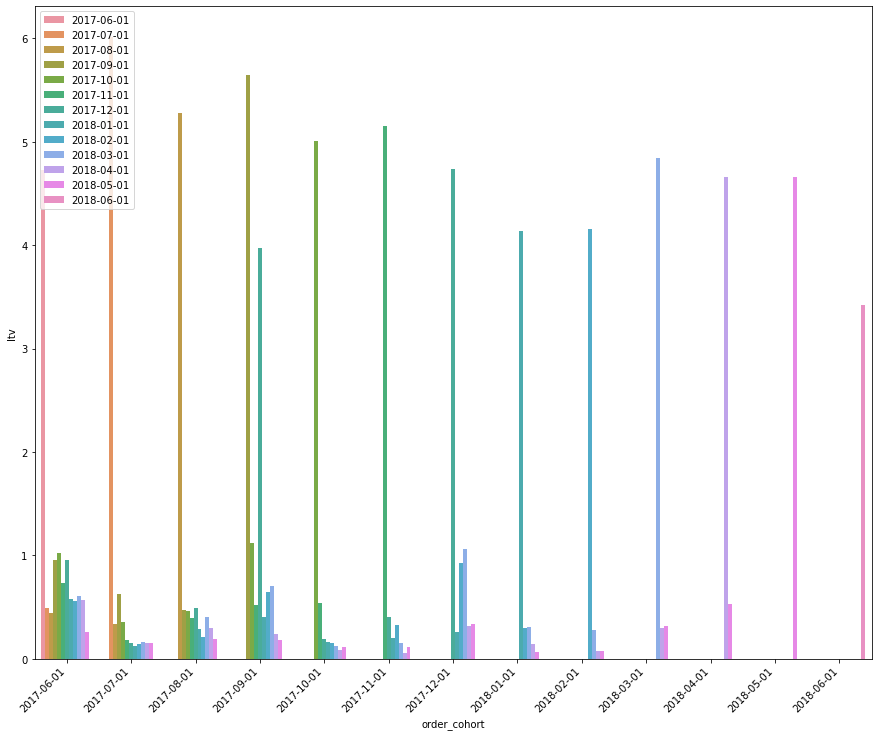

In [323]:
# Draw a nested barplot by cohort and month
fig, ax = plt.subplots()
l_dates = ltv.buy_month.dt.strftime('%Y-%m-%d').sort_values().unique()
box_plot = sns.barplot(x = ltv["order_cohort"],
                       y = ltv["ltv"],
                       hue = "buy_month",
                       hue_order=l_dates,
                       data= ltv)          
x_dates = ltv.order_cohort.dt.strftime('%Y-%m-%d').sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
fig.set_size_inches(15,12)
plt.show()

Finally, to compare cohorts, we will use cumsum:

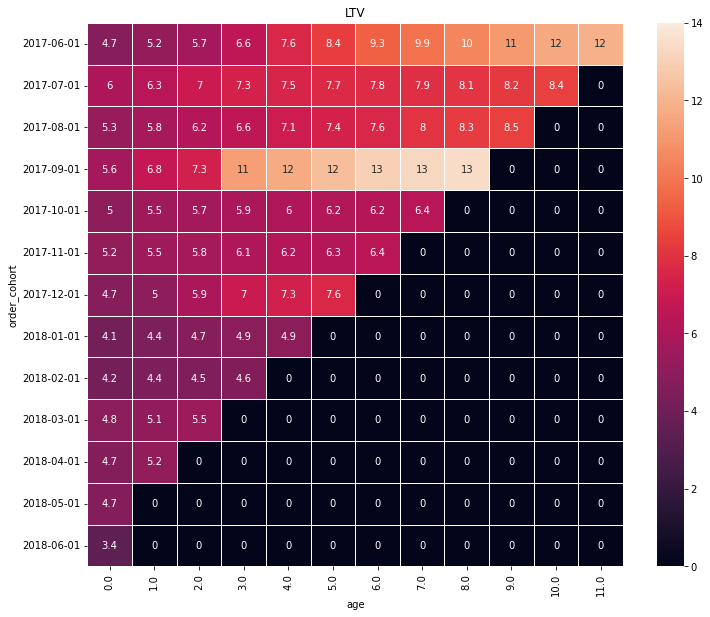

In [324]:
ltv_cum_piv = ltv.pivot_table(index='order_cohort',
                  columns='age',
                  values='ltv',
                  aggfunc='sum').cumsum(axis=1).round(2).fillna(0)

ltv_cum_piv.index = ltv_cum_piv.index.astype(str)

fig, ax = plt.subplots()
heatmap = sns.heatmap(ltv_cum_piv, annot=True, linewidths=1, linecolor='white',  vmax=14, cbar_kws= {'orientation': 'vertical'} 
            ).set(title = 'LTV')
fig.set_size_inches(12,10)
plt.show()

We can see that:
* Most purchases (ltv contribution) are made during the first month.  
Users come to buy and not often return...
* The monthly ltv contribution for the first moth is quite steady - between 4 and 6.
* Sep. cohort is the most profitable and June cohort (2017) is the second.  
But Sep. cohort sharply grows within a single month (the fourth) while June cohort gradually increases over many months.
* Dec. cohort is also much better than its adjacent months.
* The weakest cohorts appear to be Jan.-Feb.  
Maybe people already ordered most of their desired tickets in advance?  
We should refer this data to marketing.

## Marketing

### How much money was spent? Overall / per source / over time

Overall:

In [325]:
print(costs['costs'].sum())

329131.62


Per source:

In [326]:
costs_per_source = costs.groupby(['source_id'])['costs'].sum().reset_index().sort_values(by=['costs'], ascending=False)

In [327]:
print(costs_per_source)

  source_id      costs
3         3  141321.63
4         4   61073.60
5         5   51757.10
2         2   42806.04
0         1   20833.27
1        10    5822.49
6         9    5517.49


Let's visualize:

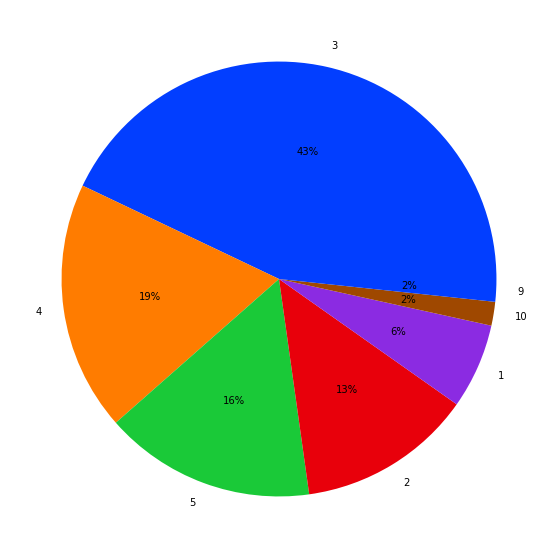

In [328]:
fig, ax = plt.subplots()
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:6]
#create pie chart
plt1 = plt.pie(costs_per_source['costs'], labels = costs_per_source['source_id'], colors = colors, autopct='%.0f%%')
fig.set_size_inches(12,10)
plt.show()

**Remark - here I wish to thank one of my previous reviewers that pointed me towards the advantages of using a pie chart... :)**

Let's check visits for marketing - if they are investing in the right sources:

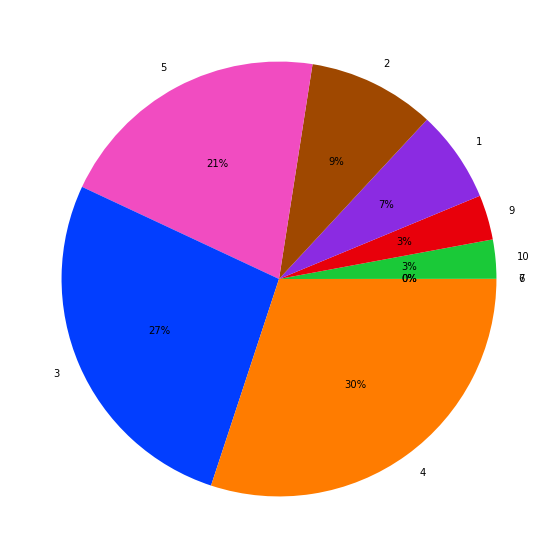

In [329]:
fig, ax = plt.subplots()
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:7]
#create pie chart
plt1 = plt.pie(source_df['unique_users'], labels = source_df['source_id'], colors = colors, autopct='%.0f%%')
fig.set_size_inches(12,10)
plt.show()

Over time:

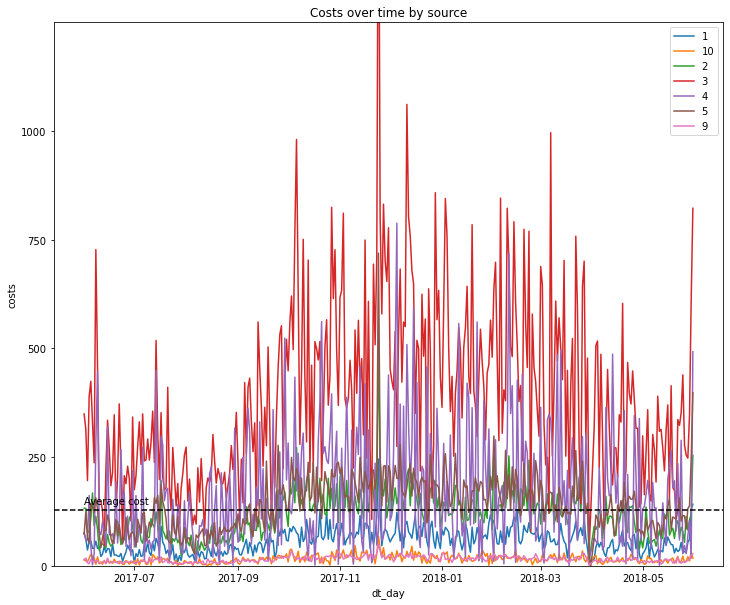

In [330]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'dt_day', y = 'costs', hue = 'source_id', data = costs)
x11 = line_plot.set_title("Costs over time by source")
x12 = ax.axhline(costs.costs.mean(), ls='--', c='black')
x13 = ax.text(costs.dt_day.min(),1.1 * costs.costs.mean(),"Average cost", c='black')
y1 = ax.set_ylim(0,1250)
y2 = ax.set_yticks(range(0,1250,250))
fig1 = fig.set_size_inches(12,10)
gen1 = plt.legend(labels=costs['source_id'].unique().sort_values())
plt.show()

To get a slightly clearer picture I will aggregate by week (data is very noisy):

In [331]:
costs_per_source_per_week = costs.groupby(['source_id', 'dt_week'])['costs'].sum().reset_index()

In [332]:
costs_per_source_per_week.head()

,source_id,dt_week,costs
0,1,2017-06-01,367.04
1,1,2017-06-08,264.55
2,1,2017-06-15,223.31
3,1,2017-06-22,201.15
4,1,2017-06-29,184.65


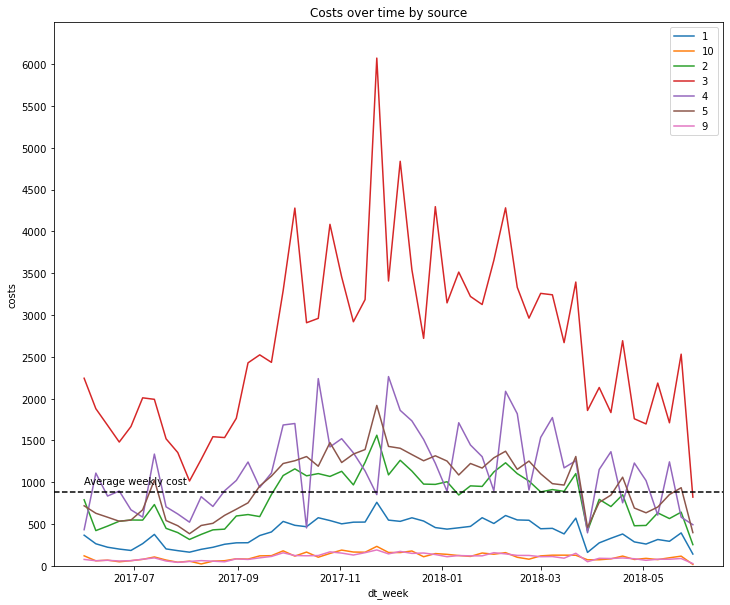

In [333]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'dt_week', y = 'costs', hue = 'source_id', data = costs_per_source_per_week)
x11 = line_plot.set_title("Costs over time by source")
x12 = ax.axhline(costs_per_source_per_week.costs.mean(), ls='--', c='black')
x13 = ax.text(costs.dt_day.min(),1.1 * costs_per_source_per_week.costs.mean(),"Average weekly cost", c='black')
y1 = ax.set_ylim(0,6500)
y2 = ax.set_yticks(range(0,6500,500))
fig1 = fig.set_size_inches(12,10)
gen1 = plt.legend(labels=costs['source_id'].unique().sort_values())
plt.show()

And by month:

In [334]:
costs_per_source_per_month = costs.groupby(['source_id', 'dt_month'])['costs'].sum().reset_index()

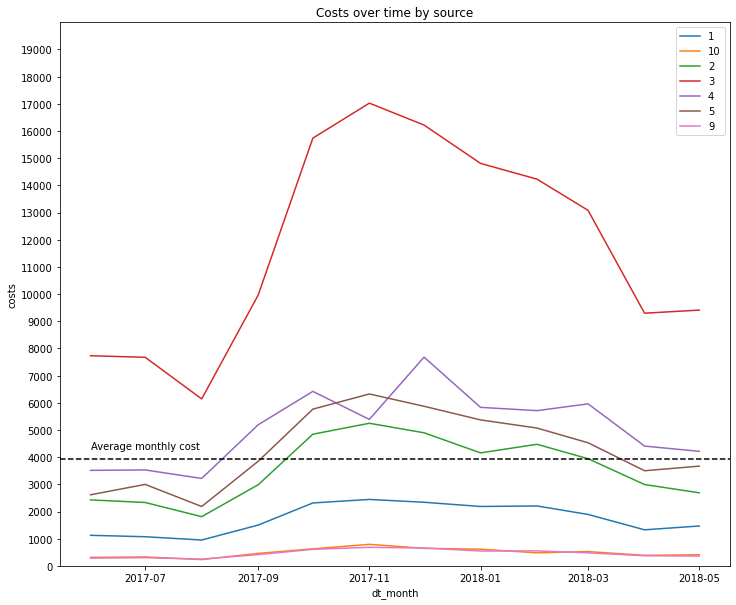

In [335]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'dt_month', y = 'costs', hue = 'source_id', data = costs_per_source_per_month)
x11 = line_plot.set_title("Costs over time by source")
x12 = ax.axhline(costs_per_source_per_month.costs.mean(), ls='--', c='black')
x13 = ax.text(costs.dt_day.min(),1.1 * costs_per_source_per_month.costs.mean(),"Average monthly cost", c='black')
y1 = ax.set_ylim(0,20000)
y2 = ax.set_yticks(range(0,20000,1000))
fig1 = fig.set_size_inches(12,10)
gen1 = plt.legend(labels=costs['source_id'].unique().sort_values())
plt.show()

We can see that:
* Sources 3 & 4 are the leading consumers of costs followed by sources 5 and 2.
* The channels costing the most are also those bringing in the most visitors.  
* However, visitors are not buyers! We will go deeper into this issue below...
* Costs spikes probably agree with marketing campaigns.  
We can see a big one during Dec. (Novi god?) and others during June, Aug. etc.  
There are at least six large campaigns per year.
* The very noisy nature of the costs suggests online (traffic dependent) or rapidly changing routes and not offline or built/designed nature. It also points towards ever changing marketing strategies :)  
This fact is further substantiated by the costs trends similarity to the DAU/WAU/MAU graphs above (section 6.1.1).  
Maybe Yandex afisha pays by clicks or CTR models to banners placed on different locations?
* The spikes frequency is higher than a week because we have clear spikes in the weekly graph but much lower than a month because the monthly graph is already relatively smooth. 
* Marketing strategy/trent is consistent across sources. When marketing is spending money (mainly starting Sep. and ending March) it does so simultaneously across all sources (obviously, not identical amounts). The same goes for spending the least (Aug. period).
* Note that revenue trends are not identical to but lag the marketing costs.  
For example, the Sep. cohort brings in most revenue arount Dec. and the Dec. cohort brings in most revenue about March (see above).  
Maybe Yandex afisha gets paid by the buisnesses (shows, theatres...) only when users finally approve their purchase and do not invoke cancellation rights?  
Maybe Yandex Afisha users only put a down payment of a certain percentage in advance when they made the order or that they use several payments and Afishe gets a percentage of each payment?  
In any event, Revenue trends are not identical to active users and costs trends.

### How much did customer acquisition from each of the sources cost?

To answer this question we need to generate a CAC (Customer Acquisition Costs) report.  
Customers are only those that actually made order - paying users from orders table!

In [341]:
costs_cohort = costs.groupby(['dt_month'])['costs'].sum().reset_index()
costs_cohort.columns = ['costs_month','marketing_costs']

In [342]:
print(costs_cohort)

   costs_month  marketing_costs
0   2017-06-01         18015.00
1   2017-07-01         18240.59
2   2017-08-01         14790.54
3   2017-09-01         24368.91
4   2017-10-01         36322.88
5   2017-11-01         37907.88
6   2017-12-01         38315.35
7   2018-01-01         33518.52
8   2018-02-01         32723.03
9   2018-03-01         30415.27
10  2018-04-01         22289.38
11  2018-05-01         22224.27


In [343]:
CAC = costs_cohort.merge(cohort_sizes,how='left',left_on=['costs_month'],right_on=['order_cohort'])
CAC.drop('order_cohort', axis=1, inplace=True)

In [344]:
CAC['CAC'] = CAC['marketing_costs'] / CAC['cohort_size']

In [345]:
print(CAC)

   costs_month  marketing_costs  cohort_size        CAC
0   2017-06-01         18015.00         2023   8.905091
1   2017-07-01         18240.59         1923   9.485486
2   2017-08-01         14790.54         1370  10.796015
3   2017-09-01         24368.91         2581   9.441654
4   2017-10-01         36322.88         4340   8.369327
5   2017-11-01         37907.88         4081   9.288870
6   2017-12-01         38315.35         4383   8.741809
7   2018-01-01         33518.52         3373   9.937302
8   2018-02-01         32723.03         3651   8.962758
9   2018-03-01         30415.27         3533   8.608907
10  2018-04-01         22289.38         2276   9.793225
11  2018-05-01         22224.27         2988   7.437841


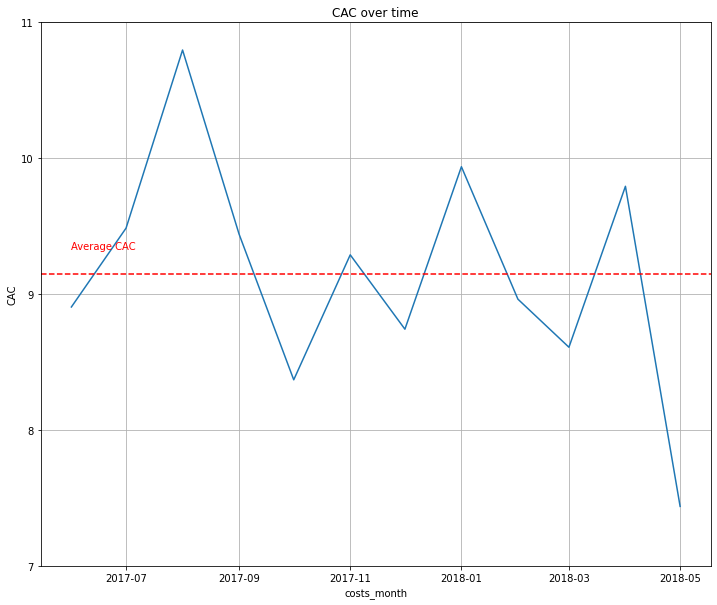

In [346]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'costs_month', y = 'CAC', data = CAC)
x11 = line_plot.set_title("CAC over time")
x12 = ax.axhline(CAC.CAC.mean(), ls='--', c='red')
x13 = ax.text(CAC.costs_month.min(),1.02 * CAC.CAC.mean(),"Average CAC", c='red')
y1 = ax.set_ylim(7,11)
y2 = ax.set_yticks(range(7,12,1))
fig1 = fig.set_size_inches(12,10)
fig2 = plt.grid()
plt.show()

We can see that:
* CAC peaks during Aug. and Jan. and plummets during Oct. and March.  
* We must not confuse CAC with marketing costs or revnue and not with DAU.  
For example, Aug. had the lowest costs, but it also had the lowest cohort size (see DAU graph), so per customer we got the highest marketing costs. In contrast, Dec. had a lot of costs, but we also got a lot of new depositers, so overall it is a very profitable month.  
* The months with the lowest CAC are those with the best fitting marketing strategy (most acquired users) compared with marketing costs.

CAC per source:

Users can come from different sources (up to 7 it appears, see below).  
Source comes from visit table and not from orders table!
So how do we define source? Is it by income, by first priority? ...  
I agree with what we were taught that the first source the user encounters is the main because:
* This is the original source that introduced the user's awareness to Yandex Afisha services.
* Yandex Afisha users typically go in and buy on the same or following day.  
For such a short period it is very logical to assume that the first source remains the one on their mind and thus the one driving the sale.  
  
For other buisnesses (with much longer typical conversion dynamics) this assumption may not necessarily be the right one or the one I would adopt. Other options are the most frequently visited source (mode) or the one associated with the most revenue.

In [347]:
print(
    visits.groupby(['Uid'])['source_id'].nunique().reset_index().sort_values(
    by = 'source_id', ascending=False).head(15))

                         Uid  source_id
87459    7060677486475916423          7
111576   9019681082555518724          7
179114  14481163132396345939          7
30185    2445395077403109224          7
15348    1242922364974949363          7
69416    5603453646174104178          7
107262   8667719997796727944          7
210837  17030528792926543083          7
99840    8056418121947262981          7
74861    6034824477503159037          6
68329    5522187531307227983          6
36541    2956019731961446550          6
214629  17339642338984417372          6
46597    3768391341321534148          6
148076  11962306486176658682          6


In [348]:
first_source = visits.sort_values('start_day').groupby('Uid').first()['source_id'].reset_index()
first_source.columns=['Uid','first_source']

In [349]:
print(first_source.head())

               Uid first_source
0   11863502262781            3
1   49537067089222            2
2  297729379853735            3
3  313578113262317            2
4  325320750514679            5


Merge back to orders:

In [350]:
orders = orders.merge(first_source,on=['Uid'],how='left')

In [351]:
print(orders.head())

               Buy Ts  Revenue                   Uid    buy_day   buy_week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-06-01   

   buy_month first_order order_cohort first_source  
0 2017-06-01  2017-06-01   2017-06-01            1  
1 2017-06-01  2017-06-01   2017-06-01            2  
2 2017-06-01  2017-06-01   2017-06-01            2  
3 2017-06-01  2017-06-01   2017-06-01            2  
4 2017-06-01  2017-06-01   2017-06-01            3  


Now we repeat CAC but by source as well as by month:

In [352]:
costs_per_month_per_source = costs.groupby(['dt_month','source_id'])['costs'].sum().reset_index()

In [353]:
costs_per_month_per_source.columns = ['costs_month', 'source_id', 'costs']

In [354]:
print(costs_per_month_per_source)

   costs_month source_id     costs
0   2017-06-01         1   1125.61
1   2017-06-01        10    314.22
2   2017-06-01         2   2427.38
3   2017-06-01         3   7731.65
4   2017-06-01         4   3514.80
5   2017-06-01         5   2616.12
6   2017-06-01         9    285.22
7   2017-07-01         1   1072.88
8   2017-07-01        10    329.82
9   2017-07-01         2   2333.11
10  2017-07-01         3   7674.37
11  2017-07-01         4   3529.73
12  2017-07-01         5   2998.14
13  2017-07-01         9    302.54
14  2017-08-01         1    951.81
15  2017-08-01        10    232.57
16  2017-08-01         2   1811.05
17  2017-08-01         3   6143.54
18  2017-08-01         4   3217.36
19  2017-08-01         5   2185.28
20  2017-08-01         9    248.93
21  2017-09-01         1   1502.01
22  2017-09-01        10    460.67
23  2017-09-01         2   2985.66
24  2017-09-01         3   9963.55
25  2017-09-01         4   5192.26
26  2017-09-01         5   3849.14
27  2017-09-01      

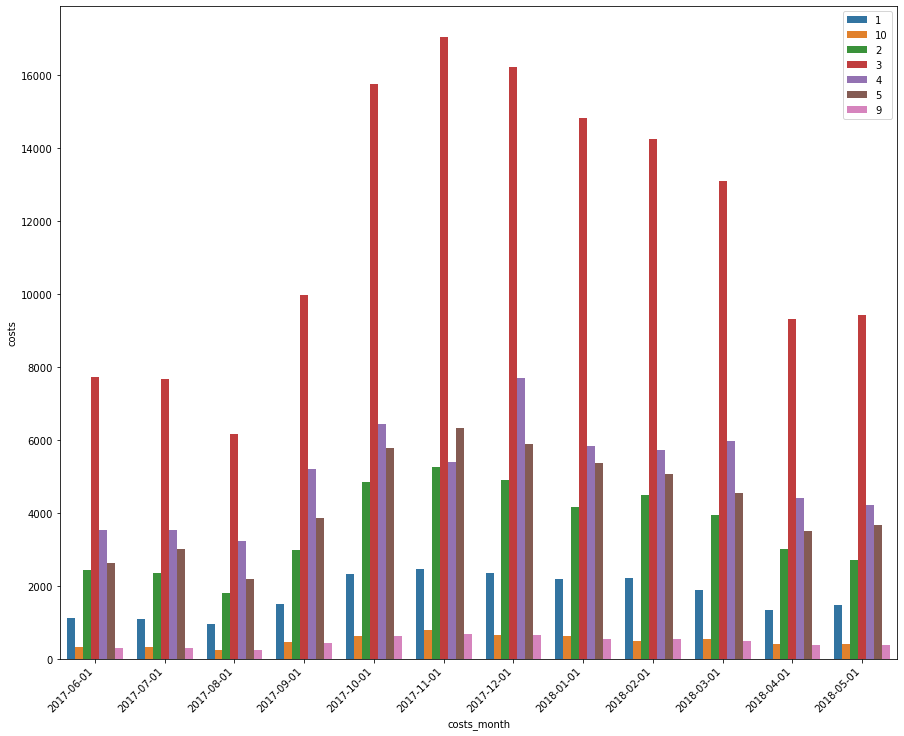

In [355]:
# Draw a nested barplot by costs_month and source
fig, ax = plt.subplots()
l_dates = costs_per_month_per_source.source_id.sort_values().unique()
box_plot = sns.barplot(x = costs_per_month_per_source["costs_month"],
                       y = costs_per_month_per_source["costs"],
                       hue = "source_id",
                       hue_order=l_dates,
                       data= costs_per_month_per_source)          
x_dates = costs_per_month_per_source.costs_month.dt.strftime('%Y-%m-%d').sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
fig.set_size_inches(15,12)
plt.show()

Unsurprisingly, we can observe that sources 3 & 4 generate the most costs, while source 5 & 2 follow.

Now we repeat the aggregation but for the number of buyes (so we can normalize to receive CAC):

In [356]:
buyers_per_month_per_source = orders.groupby(['buy_month','first_source'])['Uid'].nunique().reset_index()
buyers_per_month_per_source.columns=['costs_month','source_id','buyers_num']

In [357]:
print(buyers_per_month_per_source)

    costs_month source_id  buyers_num
0    2017-06-01         1         213
1    2017-06-01        10          94
2    2017-06-01         2         241
3    2017-06-01         3         616
4    2017-06-01         4         405
5    2017-06-01         5         389
6    2017-06-01         6           0
7    2017-06-01         7           0
8    2017-06-01         9          65
9    2017-07-01         1         209
10   2017-07-01        10          52
11   2017-07-01         2         221
12   2017-07-01         3         509
13   2017-07-01         4         507
14   2017-07-01         5         438
15   2017-07-01         6           0
16   2017-07-01         7           0
17   2017-07-01         9          48
18   2017-08-01         1         147
19   2017-08-01        10          41
20   2017-08-01         2         140
21   2017-08-01         3         359
22   2017-08-01         4         343
23   2017-08-01         5         375
24   2017-08-01         6           0
25   2017-08

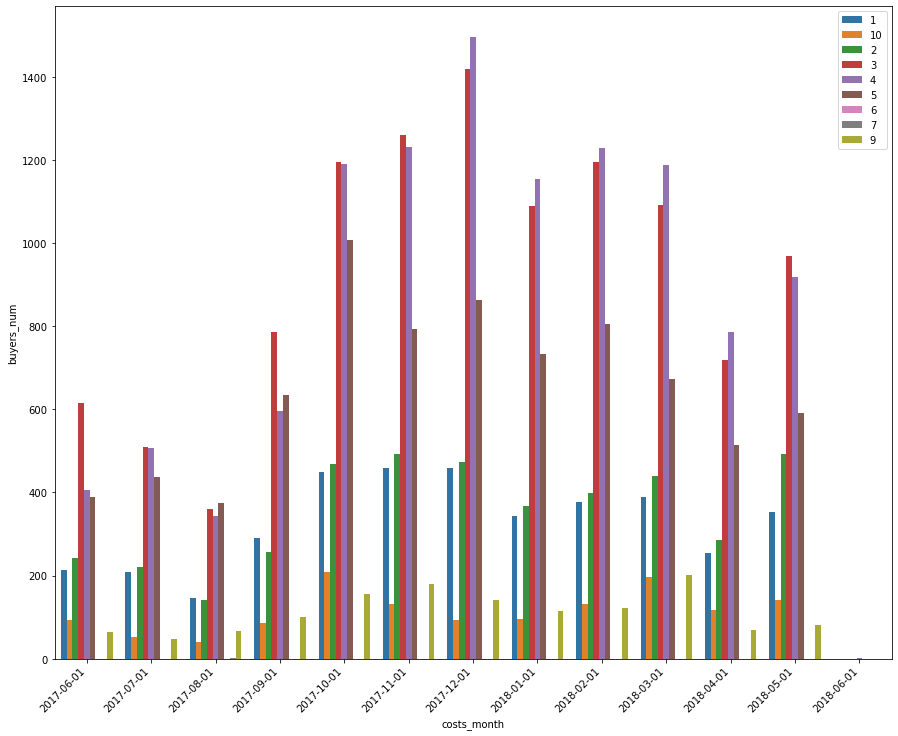

In [358]:
# Draw a nested barplot by costs_month and source
fig, ax = plt.subplots()
l_dates = buyers_per_month_per_source.source_id.sort_values().unique()
box_plot = sns.barplot(x = buyers_per_month_per_source["costs_month"],
                       y = buyers_per_month_per_source["buyers_num"],
                       hue = "source_id",
                       hue_order=l_dates,
                       data= buyers_per_month_per_source)          
x_dates = buyers_per_month_per_source.costs_month.dt.strftime('%Y-%m-%d').sort_values().unique()
x1 = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
l1 = plt.legend(loc='upper left', labels=l_dates)
hands, labs = ax.get_legend_handles_labels()
l2 = plt.legend(handles=hands, labels=labs)
fig.set_size_inches(15,12)
plt.show()

Again, we see that sources 3 & 4 bring in the most buyers, followed by sources 5 & 2.

Now we merge to calculate CAC:

In [359]:
CAC_per_month_per_source = costs_per_month_per_source.merge(
    buyers_per_month_per_source,how='left',on=['costs_month','source_id'])

In [360]:
CAC_per_month_per_source['CAC'] = CAC_per_month_per_source['costs'] / CAC_per_month_per_source['buyers_num']

In [361]:
print(CAC_per_month_per_source)

   costs_month source_id     costs  buyers_num        CAC
0   2017-06-01         1   1125.61         213   5.284554
1   2017-06-01        10    314.22          94   3.342766
2   2017-06-01         2   2427.38         241  10.072116
3   2017-06-01         3   7731.65         616  12.551380
4   2017-06-01         4   3514.80         405   8.678519
5   2017-06-01         5   2616.12         389   6.725244
6   2017-06-01         9    285.22          65   4.388000
7   2017-07-01         1   1072.88         209   5.133397
8   2017-07-01        10    329.82          52   6.342692
9   2017-07-01         2   2333.11         221  10.557059
10  2017-07-01         3   7674.37         509  15.077348
11  2017-07-01         4   3529.73         507   6.961992
12  2017-07-01         5   2998.14         438   6.845068
13  2017-07-01         9    302.54          48   6.302917
14  2017-08-01         1    951.81         147   6.474898
15  2017-08-01        10    232.57          41   5.672439
16  2017-08-01

We can also calculate the overall average CAC per source and compare how it was changing over time to each source.

In [362]:
average_CAC_per_source = CAC_per_month_per_source.groupby(['costs_month'])['CAC'].mean().reset_index()
print(average_CAC_per_source)

   costs_month       CAC
0   2017-06-01  7.291797
1   2017-07-01  8.174353
2   2017-08-01  8.739353
3   2017-09-01  7.690997
4   2017-10-01  6.670463
5   2017-11-01  7.384361
6   2017-12-01  7.198955
7   2018-01-01  7.835036
8   2018-02-01  6.868542
9   2018-03-01  6.086846
10  2018-04-01  7.122859
11  2018-05-01  5.368464


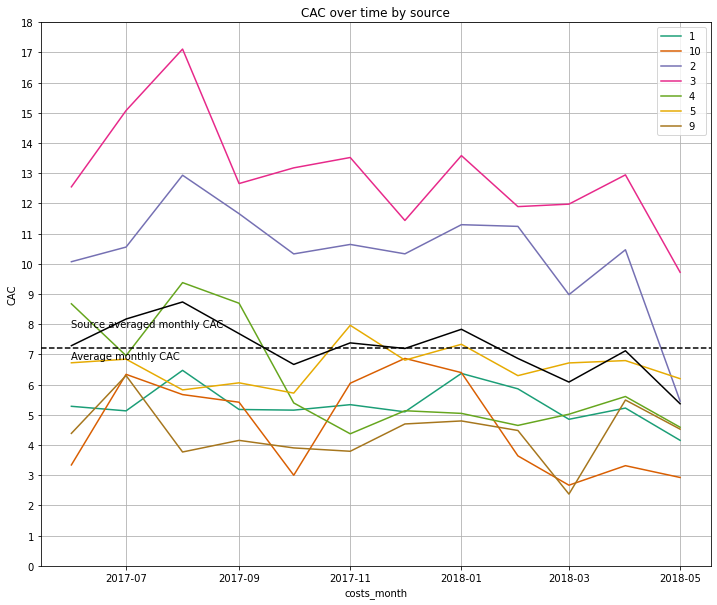

In [363]:
fig, ax = plt.subplots()
line_plot = sns.lineplot(x = 'costs_month', y = 'CAC', hue = 'source_id', palette = 'Dark2', data = CAC_per_month_per_source)
line_plot2 = sns.lineplot(x = 'costs_month', y = 'CAC', color = 'black', data = average_CAC_per_source)
x11 = line_plot.set_title("CAC over time by source")
x12 = ax.axhline(CAC_per_month_per_source.CAC.mean(), ls='--', c='black')
x13 = ax.text(CAC_per_month_per_source.costs_month.min(),0.95 * CAC_per_month_per_source.CAC.mean(),"Average monthly CAC", c='black')
x14 = ax.text(CAC_per_month_per_source.costs_month.min(),1.1 * CAC_per_month_per_source.CAC.mean(),"Source averaged monthly CAC", c='black')
y1 = ax.set_ylim(0,18)
y2 = ax.set_yticks(range(0,19,1))
fig1 = fig.set_size_inches(12,10)
#gen1 = plt.legend(labels=costs['source_id'].unique().sort_values())
fig2 = plt.grid()
plt.show()

We can see that:
* The trends are very similar to the overall CAC (peaks on Aug. and Jan.), here represented by the source-averaged monthly CAC - in black.  
However, they are not identical!  
For instance, Oct. and March are not the minimal CAC months for all sources.
* Interestingly, source 3 leads the CAC but it is then followed by source 2, not source 4.  
Some sources have higher overall costs but not when normalized by the number of generated users.
* The overall CAC is dominated by the outlier CAC sources 2&3. When they peak, the overall CAC peaks as well. Lower CAC sources (e.g., source 9) have lower effect on the overall trend.
* Very interesting is the period between Sep. and Nov. when there was a switch in CAC between sources 4 & 5.  
If marketing actively changed an approach during this period we should certainly know for which source it was. This way we can determine whether it was a successful change for source 4 or a failure for source 5...  
This can greatly assist future sales.

### How worthwhile were the investments? (ROI)

ROI (by_cohort_by_month) = LTV (by_cohort_by_month) / CAC (by_cohort)  

* CAC is calculated upfront per cohort (marketing is paying in advance) while ltv is being accumulated by the month since cohort establishment. Therefore, we will receive ROI by cohort by month.

In [364]:
CAC_ROI = CAC[['costs_month','CAC']]
CAC_ROI.columns=['order_cohort','CAC']
print(CAC_ROI.head())

  order_cohort        CAC
0   2017-06-01   8.905091
1   2017-07-01   9.485486
2   2017-08-01  10.796015
3   2017-09-01   9.441654
4   2017-10-01   8.369327


In [365]:
ROI = ltv.merge(CAC_ROI,on=['order_cohort'],how='left')
ROI['ROI'] = ROI['ltv'] / ROI['CAC']
ROI.head(15)

,order_cohort,buy_month,Revenue,cohort_size,age,ltv,CAC,ROI
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091,0.530530
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091,0.054500
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091,0.049145
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091,0.107205
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091,0.114825
5,2017-06-01,2017-11-01,1487.92,2023,5.0,0.735502,8.905091,0.082593
6,2017-06-01,2017-12-01,1922.74,2023,6.0,0.950440,8.905091,0.106730
7,2017-06-01,2018-01-01,1176.56,2023,7.0,0.581592,8.905091,0.065310
8,2017-06-01,2018-02-01,1119.15,2023,8.0,0.553213,8.905091,0.062123
9,2017-06-01,2018-03-01,1225.51,2023,9.0,0.605788,8.905091,0.068027


In [366]:
ROI_piv = ROI.pivot_table(
    index='order_cohort', columns='age', values='ROI', aggfunc='mean'
).cumsum(axis=1).round(2)#.fillna(0)

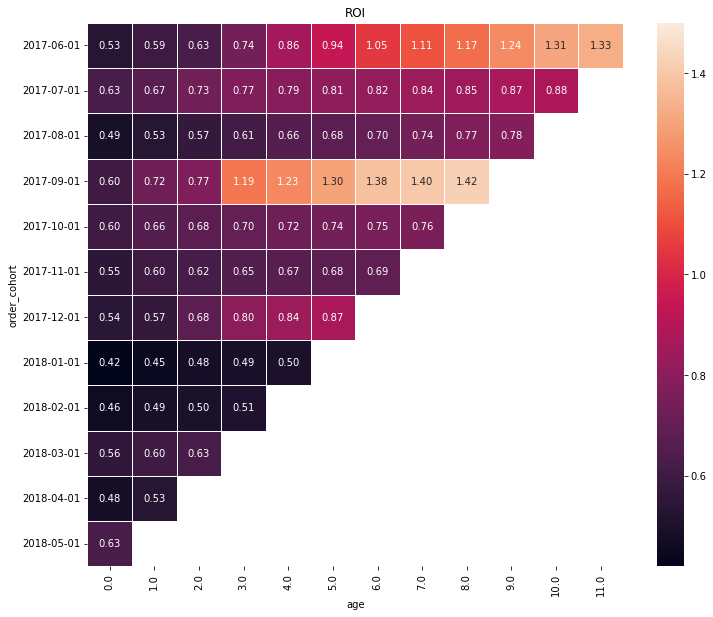

In [367]:
ROI_piv.index = ROI_piv.index.astype(str)

fig, ax = plt.subplots()
heatmap = sns.heatmap(ROI_piv, annot=True, fmt='.2f', linewidths=1, linecolor='white',  vmax=1.5, cbar_kws= {'orientation': 'vertical'} 
            ).set(title = 'ROI')
fig.set_size_inches(12,10)
plt.show()

We can see that:
* June and Sep. cohorts are the only ones profitable (ROI larger than 1 -> 1.3-1.4) with their neighboring months lagging behind (being not profitable -> average ROI of 0.69-0.87).  
[ROI must be larger than 1 to be profitable]
* The weak period starts with the new year (Jan. 2018) where ROI drops to ~0.5-0.6 values.
* Sep. cohort is even more profitable than June because it reaches higher ROI values and even with faster dynamics.
* Perhaps by Dec. the users already ordered everything expensive in advance and a month or two later the weather starts changing and they are no longer looking for indoor activities?
* Though marketing is investing in the large traffic sources, most cohorts are still not profitable enough. There is yet work to be done.

If we wish to analyze ROI for the first source only:

ROI (by_cohort_by_first-source) = LTV (by_cohort_by_month_by_first-source) / CAC (by_cohort_by_first-source)

In [368]:
ltv_first_source=orders.groupby(['first_source'])[['Uid','Revenue']].agg({'Uid':'nunique','Revenue':'sum'}).reset_index()

In [369]:
ltv_first_source.columns=['first_source','buyers_num','Revenue']

In [370]:
ltv_first_source['ltv']=ltv_first_source['Revenue'] / ltv_first_source['buyers_num']

In [371]:
print(ltv_first_source.sort_values(by = 'ltv', ascending = False))

  first_source  buyers_num   Revenue        ltv
2            2        3556  45335.95  12.749142
0            1        3365  34797.27  10.340942
5            5        7109  54442.14   7.658199
4            4        9999  55387.40   5.539294
8            9        1054   5538.50   5.254744
3            3       10137  51958.06   5.125585
1           10        1302   4596.66   3.530461
7            7           1      1.22   1.220000
6            6           0      0.00        NaN


We can see that buyers arriving from sources 2&1 generate double the value than buyers arriving from sources 3 & 4 (which we considered to be of the highest revenue).  
This is not surprising as we already know that we can get numerous customers making small purchases or less customers making larger purchases.  
In any event, the first source is a very potent predictor of the customer ltv.  
  
Remark - there are no buyers with source 6 as their primary (first) source, so this source yields a null ltv.

In [372]:
roi_first_source = costs_per_source.merge(ltv_first_source, how = 'left', left_on=['source_id'], right_on=['first_source'],)

In [373]:
roi_first_source = roi_first_source.drop(labels = 'first_source', axis=1, inplace=False)

In [374]:
roi_first_source['CAC'] = roi_first_source['costs'] / roi_first_source['buyers_num']
roi_first_source['ROMI'] = roi_first_source['ltv'] / roi_first_source['CAC']

In [375]:
print(roi_first_source.sort_values(by = 'ROMI', ascending = False))

  source_id      costs  buyers_num   Revenue        ltv        CAC      ROMI
4         1   20833.27        3365  34797.27  10.340942   6.191165  1.670274
3         2   42806.04        3556  45335.95  12.749142  12.037694  1.059102
2         5   51757.10        7109  54442.14   7.658199   7.280504  1.051878
6         9    5517.49        1054   5538.50   5.254744   5.234810  1.003808
1         4   61073.60        9999  55387.40   5.539294   6.107971  0.906896
5        10    5822.49        1302   4596.66   3.530461   4.471959  0.789466
0         3  141321.63       10137  51958.06   5.125585  13.941169  0.367658


In [376]:
roi_first_source['source_id'] = roi_first_source['source_id'].astype('int')

In [377]:
roi_first_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   source_id   7 non-null      int32  
 1   costs       7 non-null      float64
 2   buyers_num  7 non-null      int64  
 3   Revenue     7 non-null      float64
 4   ltv         7 non-null      float64
 5   CAC         7 non-null      float64
 6   ROMI        7 non-null      float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 420.0 bytes


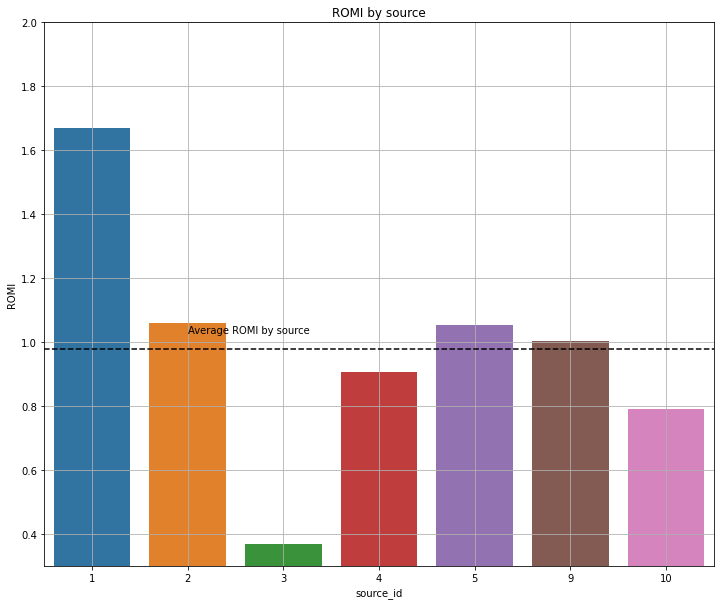

In [378]:
fig, ax = plt.subplots()
bar_plot = sns.barplot(x = 'source_id', y = 'ROMI', data = roi_first_source)
x11 = bar_plot.set_title("ROMI by source")
x12 = ax.axhline(roi_first_source.ROMI.mean(), ls='--', c='black')
x13 = ax.text(roi_first_source.source_id.min(),1.05 * roi_first_source.ROMI.mean(),"Average ROMI by source", c='black')
y1 = ax.set_ylim(0.3,2)
#y2 = ax.set_yticks(range(0,2.1,0.1))
fig1 = fig.set_size_inches(12,10)
fig2 = plt.grid()
plt.show()

It is very clear that sources 1, 2 & 5 are profitable per user (1 the most) while source 3 is the least profitable.  
So channels 3 & 4 (particularly 3) bring in a lot of customers but these customers are not buying enough to return marketing expenses.  
We need to take money invested in sources 3 & 4 and transfer it to sources 1 (most), 2 & 5.  
Also, have marketing check what income (ltv) we get from viral/organic buyers (coming from friends, surfing the web, etc. and not from active marketing activities that cost money). This way we can have a 'control' group for the marketing expenses.

We can also use a simplified approach of comparing revenue and costs:

In [379]:
Revenue_per_source = orders.groupby(['first_source'])['Revenue'].sum().reset_index()

In [380]:
Revenue_per_source.columns = ['source', 'Revenue']

In [381]:
print(Revenue_per_source)

  source   Revenue
0      1  34797.27
1     10   4596.66
2      2  45335.95
3      3  51958.06
4      4  55387.40
5      5  54442.14
6      6      0.00
7      7      1.22
8      9   5538.50


In [382]:
costs_per_source = costs.groupby(['source_id'])['costs'].sum().reset_index()

In [383]:
costs_per_source.columns = ['source', 'costs']

In [384]:
print(costs_per_source)

  source      costs
0      1   20833.27
1     10    5822.49
2      2   42806.04
3      3  141321.63
4      4   61073.60
5      5   51757.10
6      9    5517.49


In [385]:
profit = Revenue_per_source.merge(costs_per_source, how = 'inner', on=['source'])

In [386]:
profit ['profit'] = profit['Revenue'] - profit['costs']

In [387]:
print(profit)

  source   Revenue      costs    profit
0      1  34797.27   20833.27  13964.00
1     10   4596.66    5822.49  -1225.83
2      2  45335.95   42806.04   2529.91
3      3  51958.06  141321.63 -89363.57
4      4  55387.40   61073.60  -5686.20
5      5  54442.14   51757.10   2685.04
6      9   5538.50    5517.49     21.01


Again, we can see that source 1 is the most profitable, followed by 2 & 5 while sources 3 (considerably), 4 and 10 are losing money. 

In [388]:
Revenue_per_cohort = orders.groupby(['order_cohort'])['Revenue'].sum().reset_index()
Revenue_per_cohort.columns = ['cohort', 'Revenue']
print(Revenue_per_cohort)

       cohort   Revenue
0  2017-06-01  24031.69
1  2017-07-01  16127.92
2  2017-08-01  11606.26
3  2017-09-01  34676.32
4  2017-10-01  27603.45
5  2017-11-01  26098.99
6  2017-12-01  33485.74
7  2018-01-01  16663.13
8  2018-02-01  16750.50
9  2018-03-01  19273.41
10 2018-04-01  11810.61
11 2018-05-01  13925.76
12 2018-06-01      3.42


In [389]:
costs_per_cohort = costs.groupby(['dt_month'])['costs'].sum().reset_index()
costs_per_cohort.columns = ['cohort', 'costs']
print(costs_per_cohort)

       cohort     costs
0  2017-06-01  18015.00
1  2017-07-01  18240.59
2  2017-08-01  14790.54
3  2017-09-01  24368.91
4  2017-10-01  36322.88
5  2017-11-01  37907.88
6  2017-12-01  38315.35
7  2018-01-01  33518.52
8  2018-02-01  32723.03
9  2018-03-01  30415.27
10 2018-04-01  22289.38
11 2018-05-01  22224.27


In [390]:
profit_cohort = Revenue_per_cohort.merge(costs_per_cohort, how = 'inner', on=['cohort'])

In [391]:
profit_cohort ['profit'] = profit_cohort['Revenue'] - profit_cohort['costs']

In [392]:
print(profit_cohort)

       cohort   Revenue     costs    profit
0  2017-06-01  24031.69  18015.00   6016.69
1  2017-07-01  16127.92  18240.59  -2112.67
2  2017-08-01  11606.26  14790.54  -3184.28
3  2017-09-01  34676.32  24368.91  10307.41
4  2017-10-01  27603.45  36322.88  -8719.43
5  2017-11-01  26098.99  37907.88 -11808.89
6  2017-12-01  33485.74  38315.35  -4829.61
7  2018-01-01  16663.13  33518.52 -16855.39
8  2018-02-01  16750.50  32723.03 -15972.53
9  2018-03-01  19273.41  30415.27 -11141.86
10 2018-04-01  11810.61  22289.38 -10478.77
11 2018-05-01  13925.76  22224.27  -8298.51


Here we can see that the Sep. cohort is the most profitable, followed by the June cohort.  
The other cohorts are losing money (July and Aug. leading the loosing list...)

So the simplified calculation is leading to conclusions that are quite similar to those we received before using ROMI, LTV and CAC.

## Some device category aspects

Let us investigate some device aspects:

In [393]:
examine(visits[visits['Device'] == 'desktop'])
print(visits[visits['Device'] == 'desktop']['End Ts'].min())
print(visits[visits['Device'] == 'desktop']['End Ts'].max())
print(visits[visits['Device'] == 'desktop']['Start Ts'].min())
print(visits[visits['Device'] == 'desktop']['Start Ts'].max())
print(visits[visits['Device'] == 'desktop']['first_order'].count() / visits[visits['Device'] == 'desktop']['Uid'].count())


***************
 head:
     Device              End Ts source_id            Start Ts  \
1  desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
3  desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   
5  desktop 2017-09-03 21:36:00         5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00         1 2018-01-30 11:13:00   

                    Uid  start_day start_week start_month    end_day  \
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01 2018-02-19   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01 2018-05-20   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01 2017-12-27   
5  16007536194108375387 2017-09-03 2017-08-31  2017-09-01 2017-09-03   
6   6661610529277171451 2018-01-30 2018-01-25  2018-01-01 2018-01-30   

    end_week  end_month  session_length first_session     cohort  age  \
1 2018-02-15 2018-02-01        0.466667    2018-02-19 2018-02-01    0   
3 2018-05-1

In [394]:
examine(visits[visits['Device'] == 'touch'])
print(visits[visits['Device'] == 'touch']['End Ts'].min())
print(visits[visits['Device'] == 'touch']['End Ts'].max())
print(visits[visits['Device'] == 'touch']['Start Ts'].min())
print(visits[visits['Device'] == 'touch']['Start Ts'].max())
print(visits[visits['Device'] == 'touch']['first_order'].count() / visits[visits['Device'] == 'touch']['Uid'].count())


***************
 head:
    Device              End Ts source_id            Start Ts  \
0   touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
2   touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
7   touch 2017-11-05 15:15:00         3 2017-11-05 15:14:00   
14  touch 2018-04-23 18:01:00         9 2018-04-23 18:00:00   
15  touch 2018-02-12 20:30:00         2 2018-02-12 19:24:00   

                     Uid  start_day start_week start_month    end_day  \
0   16879256277535980062 2017-12-20 2017-12-14  2017-12-01 2017-12-20   
2    7459035603376831527 2017-07-01 2017-06-29  2017-07-01 2017-07-01   
7   11423865690854540312 2017-11-05 2017-11-02  2017-11-01 2017-11-05   
14  18026419100367255411 2018-04-23 2018-04-19  2018-04-01 2018-04-23   
15  18188358787673499603 2018-02-12 2018-02-08  2018-02-01 2018-02-12   

     end_week  end_month  session_length first_session     cohort  age  \
0  2017-12-14 2017-12-01        0.300000    2017-12-20 2017-12-01    0   
2  2017-0

Conclusions:
* There are no significant differences between desktop and touch devices in terms of visits time span and conversion time distributions.
* However, roughly 30% of desktop users do eventually place orders while only 20% of touch users do.
* Therefore, if we segregate these two groups (like above), I suspect that the desktop users will present higher profit than the touch users (lower CAC and higher LTV).
* In general, this could make sense because touch users are typically younger (youth and children) and should have less money to purchase costly shows.  
* **However**, such a simplified reasoning as I made above is very dangerous.  
Some users have both touch and desktop devices (see proof below).  
Maybe, they were surfing the site using their ipad or cell, decided they want to go see a show and then later returned to order tickets at home on their desktop.  
This could be solved using a first device approach as we used above for the first source.  
* But, people go to shows or movies in groups and not alone. For example, I have kids and it is not uncommon for them to look for a movie or a show using their cell phones, not order anything (because they have no money or credit card) and then come to me to make the order for them (which I typically do using my desktop). I even sometimes join them and purchase a ticket for myself as well or for my wife to accompany them. In this case I claim that the purchase originator device is their cell phone touch and not my desktop with which the final order was made. Similar chain of events can often happen with my wife.  
I am simply too busy with Yandex project to place orders... :) 

I therefore conclude that further device analysis in my view is quite problematic and may even be fruitless or missleading here and requires a specialized analysis not currently possible using our available database.  
It is not efficient for marketing to target my desktop when in fact my kids touch devices or my wife ipad (also touch) are the ones originating the purchase...  
At the very least, I would look for an ip address or some connectivity between different users logging on from the same ip. This could be aggregated as a group entity (e.g., family) for which the first visit may represent the actual originator device...

In [395]:
print(
    visits.groupby(['Uid'])['Device'].nunique().reset_index().sort_values(
    by = 'Device', ascending=False).head(15))

                         Uid  Device
132474  10695240366599660152       2
21252    1724693760721641828       2
122298   9887864976816243302       2
221459  17902667191250257068       2
188122  15202288659943748638       2
81810    6594465659963201893       2
14220    1155475205745446228       2
207598  16770225033832693969       2
53963    4360486923389958592       2
202287  16346192184877410169       2
41462    3357253622010423519       2
6963      568663938262544232       2
96167    7762556406166511932       2
41460    3357062870524537488       2
122313   9888971897764422801       2


# Step 3. Write a conclusion: advise marketing experts how much money to invest and where.

This project task was to help optimize Yandex.Afisha marketing expenses by studying:
* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off

## Traffic / seasonality aspects

Yandex.Afisha is an average traffic site with DAU on the order of a few hundreds to a couple of thousands (in general…), up to 10000 WAU and up to 30+ thousands MAU.  
Traffic is very seasonal with a low period during summer and a high period during winter.  
In terms of orders, we get an abundance of low value orders with occasional significant orders that act as outliers.  
Costs follow the same pattern (right skew).  
In terms of persistence (stickiness), the weekly sf (DAU/WAU) is centered around 15-18% and the monthly sf (DAU/MAU) is centered around 3-5%.  
Thus, Yandex.Afisha does not attract very ‘loyal’ persisting customers.  
It is a mainly daily business.  
Weekly sf peaks during 3 main periods - June, Dec. and April. Maybe due to marketing deals or holidays (Novi God?).  
Monthly sf ranges between 3.9 and 4.5 with a real considerable peak only during Nov.  
These are reasonable numbers. Articles refer to 25% as the gold standard (average monthly sf ~10-13). Also, it is well-established that e-commerce is a low stickiness field (see above).  
  
These results make sense.  
Yandex.Afisha typically sells tickets to indoor activities - movies, concerts, shows…  
We are supposed to encounter a boost in sales during the cold season.  
The fast traffic changes on Yandex.Afisha could indicate ever changing marketing strategies.  
If so, do we have enough time to learn the outcome of these changes during the strong season?  
Maybe real-time A/B tests are required during this period?...  
  
The user ‘short life’ on Yandex.Afisha is also expressed by:
* Low average daily session per user ratio (1.05-1.15), that does not exceed 1.2.
* Very short session length (0.08 hr = 5 min median).
* Most visits/orders being performed on the first month (age 0 of cohort).
* Low retention rates (with low life span…) across the board, not exceeding 8%.  
(The only reasonable retention rates coincide with the Sep./Oct. cohorts on their second month – agrees with the traffic peak on Nov.)
* Short conversion periods, on average 50% below 1 day (with exceptions for few cohorts like Aug, Nov. and May which may have joined during a sales promotion period or the like). Less than 25% return to make orders after more than 37 days.
* A high overall order rate of 16%.
* Monthly orders per buyer not exceeding 1.2 on average (coincides with visits) and mainly concentrated on the first month since registration (cumulatively not exceeding 2.2 orders per buyer). The orders per buyer are persistent all year round (even during the top sales season of Oct. – Dec. which attracts more users).  

**The conclusions are clear:**  
Yandex afisha does not have a large 'regular' customer baseline.  
Our users come to buy.  
Many already know what they want and intend to purchase.  
They do not stay connected.  
If they did not find what they were looking for, they are leaving to return on another day (at best).  
We must hook them on their first visit if we wish to make money.  
The every few months spikes in visits are expected because most of us cannot afford tickets to concert or opera or show/musical more than two or three times a year. Unfortunately, these tickets are expensive.  
If we do not hook the user immediately, we may be losing him/her for several months…  
Therefore, we need aggressive marketing that users notice.  
Not something subtle that lingers in your subconscious for weeks before surfacing.  

Yandex.Afisha sales will not increase much by generating more orders per buyer.  
These are very persistent across cohorts.  
We must increase visitors!  
A good example is Ali Express. They bombard you through the application and e-mails with deals and some of these do hook.  
But Ali express (I think) is too aggressive.  
We are targeting a slightly ‘higher’ crowd here…  
  
This is very important for marketing to know as they pay money upfront - for the initial cohort size (to attract the customers). They should therefore assume that these are largely one timers. Then they can predict what monthly expenses can the buisness accomodate and still remain profitable.  
  
The critical period is Oct. - Dec. (these cohorts convert the most).  
This is the season when people start thinking about indoor activities and use Yandex Afisha services.  
It is probably not Jan.-Feb. because tickets need to be ordered in advance.  
So marketing should focus on these months.  
Furthermore, in the long run, the June cohort is the most profitable and the July and Oct. cohorts are the weakest. Marketing should particularly pay attention to the latter cohorts.

## Sales aspects

Our ARPPU is low (on average 6.9 and the median is less than half that – 3.05).  
Our average check is also low (on average 4.09 and the median is 2.49).  
The overall average revenue is ~5$ per row.  
The monthly revenue from each user (monthly ltv) is about 4-5$ for the first month (quite steady) and then it drops by a factor of ~5 to around 1.  
The cumulative ltv does not exceed 13 for the most profitable cohorts (June and Sep.) - roughly 3 times our average check at best. This means that at most we get three purchases per user (average...).  
  
Marketing should work on increasing the single purchase value.  
Yandex.Afisha website offers much more costly products (see above).  
How can we convince our customers to buy more costly tickets or earn more money in other ways?  
Maybe we should offer beverages (snacks, drinks…) as a deal with our tickets?  
Maybe we should offer ticket bundles? (buy a show and get a movie…).  
There are other creative ways to earn money using Yandex.Afisha access to our customers.  
  
Whatever made the Sep. cohort sharply grow in ltv within a single month during Dec. (from 7.3 to 11) should be understood. It could be a key lead.  
  
Also, Jan.-Feb. cohorts appear to be very ineffective. Probably because the costly tickets were already sold a month or so in advance (during Oct. – Nov.) and after a month or so (March-April) we enter the weak season. Marketing should either come up with a way to increase ltv for these cohorts or we should cut expenses on trying to attract them.

## Costs aspects

Marketing is investing in the sources with most traffic (3 & 4, and then 5 & 2) instead of in the sources eventually bringing in the most profit per visit (conversion and then purchase size).  
We see this by the close resemblance in distribution and dynamics of traffic and costs.  
  
CAC (Customer Acquisition Costs) indicates marketing spends a relatively narrows range (7.5 to 11) in each cohort.  
Is it wise to invest in empty cohorts like Jan. and Feb. the same amount as in profitable ones like Nov. & Dec.? I think not. Our buyers are making orders ’by the day’...  
  
We see the losses in the ROI metrics that are lower than 1 for most cohorts (only June and Sep. are profitable).  
There is yet work to be done.  
Sep. cohort is the most profitable because it reaches high ROI values very fast. We need to understand what makes this cohort so attractive and reproduce it.  
  
The costs are probably traffic dependent (maybe pay by click or CTR models to banners placed on different locations). I think marketing should consider some old school reinforcement during the weak season – radio, t.v., newspapers. People are obviously outside and not surfing the necessary websites, so what do we have to lose trying to raise their consciousness in another way…?

## Source aspects

Some sources bring much more visits than others (source id 4 vs 6 for instance).  
However, the highest traffic generating sources are not necessarily the most stable sources for retention or the most profitable.  
Source 4 (the highest users generating source) provides nearly no returning users while source 1 provides users that typically return for at least 3 months. The same goes for sources 2 and 9.  
Marketing should investigate what makes users coming from these sources return more and try implementing these drivers in source 4 users (if possible). This can greatly assist revenue.  
For instance, buyers arriving from sources 2&1 generate double the value than buyers arriving from sources 3 & 4 (numerous customers making small purchases instead of less customers making larger purchases).  
  
The first source is a very potent predictor of the customer ltv (by up to a factor of 12) and a good predictor of ROMI (by up to a factor of 5). We should exploit this knowledge.  

Sources 1, 2 & 5 are profitable per user (1 the most) while source 3 is the least profitable.  
So, sources 3 & 4 (particularly 3) bring in a lot of customers but these customers are not buying enough to return marketing expenses.  
We need to take money invested in sources 3 & 4 and transfer it to sources 1 (most), 2 & 5.  
  
Also, we should remove sources 6, 7 – they present minimal visits and nearly no conversion.  
They are probably not worth the maintenance involved (unless they are for pilots or A/B tests or research … and then they are present for reasons other than making immediate money).  
But this is a small issue…  
  
The overall CAC is dominated by the outlier CAC sources 2&3.  
When they peak, the overall CAC peaks as well.  
Lower CAC sources (e.g., source 9) have lower effect on the overall trend.  
Marketing should focus on cutting expenses on sources 2 & 3.  
  
During the period between Sep. and Nov. there was a switch in CAC between sources 4 & 5.
If marketing actively changed an approach during this period, we should certainly know for which source it was. This way we can determine whether it was a successful change for source 4 or a failure for source 5, or both...  
This can greatly assist future sales.

## Device aspects

Rroughly 30% of desktop users do eventually place orders while only 20% of touch users do.  
If we segregate these two groups, I suspect the desktop users will present higher profit than the touch users.  
This could make sense because touch users are typically younger (youth and children) and should have less money to purchase costly shows.  
However, such a simplified reasoning is very dangerous.  
Some users have both touch and desktop devices.  
But, more important, unlikek surfing the web, people go to shows or movies in groups and not alone.  
The purchase originator device (user) is not necessarily the one finally making the order.  
In my view, the current database is not efficient enough for marketing to reach substantiated conclusions on the effect of devices on sales or costs.